In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import sys

In [152]:
N_x = 16
N_y = 8
N_tot = N_x*N_y 
V = 1.
t = -V
U = 8.0
D = V
#mu = 0
Doping = 1./8
print(Doping*N_tot)
n_filling = 1.- Doping#1 for half-filling 
t_prime = 0.0
Periodic_Boundaries_x = False
Periodic_Boundaries_y = True
TwoBandModel = False
Magnetic_z_bias = False


np.set_printoptions(threshold=sys.maxsize,suppress=True)

16.0


In [153]:
H_0 = np.zeros([2*N_tot,2*N_tot])#Hamiltonian without any Deltas
#GapVector = np.zeros(4*N_tot) #Contains first the n_ups, then n_downs, then Re(d_up d_down), then Im

In [154]:
QuantumNumbers = []  #To write a single index insead of (x,y,s).
for i in range(N_y):
    for j in range(N_x):
        for s in (1,-1):
            QuantumNumbers.append([j,i,s])

In [155]:
H_0 = np.zeros([2*N_tot,2*N_tot],dtype = "complex")  #Fill up H_0 without the Gaps

for i in range(2*N_tot):     
    for j in range(2*N_tot):  
        x1,y1,s1 = QuantumNumbers[i]
        x2,y2,s2 = QuantumNumbers[j]
        
        #Implement Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(s1 == s2 and y1 == y2):
                H_0[i,j]+= t
        
        if(y1 ==y2+1 or y1 == y2-1):
            if(s1 == s2 and x1 == x2):
                H_0[i,j]+= t
        
        
        #Implement Next-Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(y1 ==y2+1 or y1 == y2-1):
                if(s1 == s2):
                
                    H_0[i,j]+= t_prime

                
                
        if(Periodic_Boundaries_x == True): #implement boundaries
            
            #for nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
            if(x2 == 0 and x1 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
                    
        if(Periodic_Boundaries_y == True):
            
            #for nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
            if(y1 == 0 and y2 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
                    
                    
        if(Periodic_Boundaries_x == True):
            #WARNING: Only one True is not implemented yet!!!
            
            #For next nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1%N_y ==y2+1 or y1%N_y == y2-1): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                            
                            
            if(x2 == 0 and x1 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1%N_y ==y2+1 or y1%N_y == y2-1):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                        
        if(Periodic_Boundaries_y == True):
            
            #For next nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):  # Here without the modulus, since else we would double count the corner-corner hopping
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(y1 == 0 and y2 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
                    
                    
                    
        if(TwoBandModel == True): #implement offset if the atoms are distinct
            if(x1==x2 and y1==y2 and s1 ==s2):
                if((x1%2 == y1%2)):
                    H_0[i,j]+=D
        if(Magnetic_z_bias == True): #apply a tiny magnetic field
            if(x1 ==x2 and y1 == y2):
                if(s1==s2==1):
                    H_0 +=0.0001
            
H_0 = np.array(H_0) 

In [156]:
def Get_H(GapVector,H_0): #Returns the full Hamiltonian for a given GapVector
    
    H = np.array(H_0)
    
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    Re_up_down = GapVector[2*N_tot:3*N_tot]
    Im_up_down = GapVector[3*N_tot:4*N_tot]
    
    for i in range(2*N_tot):     #Fills up H entrywise
        for j in range(2*N_tot):
            
            x1,y1,s1 = QuantumNumbers[i]
            x2,y2,s2 = QuantumNumbers[j]
            
            SiteIndex = N_x*y1+x1
            
            if(x1 == x2 and y1 == y2):

                if(s1 == s2 ==1):
                    H[i,j] += U*N_downs[SiteIndex]
                if(s1 == s2 ==-1):
                    H[i,j] += U*N_ups[SiteIndex]
                if(s1==1 and s2 ==-1):
                    H[i,j] += U*(-Re_up_down[SiteIndex]+1j*Im_up_down[SiteIndex]) 
                if(s1==-1 and s2 ==1):
                    H[i,j] += U*(-Re_up_down[SiteIndex]-1j*Im_up_down[SiteIndex]) 
                    
    return np.array(H)

In [157]:
def Exp_Val(g,g_prime,Matrix):
    N_filled = int(N_tot*n_filling)
    Exp = 0.
    for i in range(N_filled):
        Exp += Matrix[g,i].conjugate()*Matrix[g_prime,i]
    return Exp
    

In [158]:
def Next_Gap_Vector(GapVector,GetEnergy=False,ReturnBoth = False):
    H = Get_H(GapVector,H_0)
    epsilons, Matrix = np.linalg.eigh(H)
    
    
    
    #epsilons = np.diag(epsilons)
    N_ups_new = []
    N_downs_new = []
    Re_UpDown = []
    Im_UpDown = []
    for i in range(N_tot):
        N_ups_new.append(np.real(Exp_Val(2*i,2*i,Matrix)))
        N_downs_new.append(np.real(Exp_Val(2*i+1,2*i+1,Matrix)))
        D_up_down = Exp_Val(2*i,2*i+1,Matrix)
        Re_UpDown.append(np.real(D_up_down))
        Im_UpDown.append(np.imag(D_up_down))
    NewGapVector = np.append(N_ups_new,np.append(N_downs_new,np.append(Re_UpDown,Im_UpDown)))
    
    if(GetEnergy == True):
        N_ups = GapVector[:N_tot]
        N_downs = GapVector[N_tot:2*N_tot]
        D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:4*N_tot]
        
        #To calculate the energy, i think Gunnarsson and Zaanen have a sign error in their very last term of eq. 2.
        
        Energy = sum(epsilons[:int(N_tot*n_filling)]) - U*sum(N_ups*N_downs) + U*sum(np.real(D_UpDowns)**2)+U*sum(np.imag(D_UpDowns)**2)
        if(ReturnBoth == False):
            return Energy / int(N_tot) #- U*(n_filling/2)**2 ###last term to match with Pietro.
        if(ReturnBoth == True):
            return np.real(NewGapVector), Energy/int(N_tot)
    return np.real(NewGapVector)

#GapVector = np.load("GapVectors_Withdoping/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}.npy".format(N_x,N_y,U,Doping,2000,t_prime))
#Next_Gap_Vector(GapVector,GetEnergy=True)


In [159]:
RandVec = np.random.random(N_tot)
RandVec2 = RandVec # =RandVec, if we want to enforce the polarization plane to lie in x-y-plane.
GapVector = np.append(RandVec,np.append(RandVec2,np.random.random(2*N_tot)-0.5))

#GapVector = np.load("ToBeTransferred/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}.npy".format(N_x,N_y,2,Doping,2000,0.2))

0
0.7690698620484802


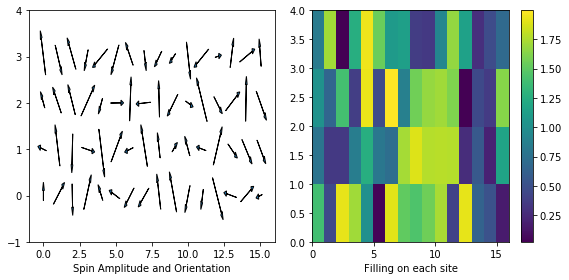

20
0.47729278387419977


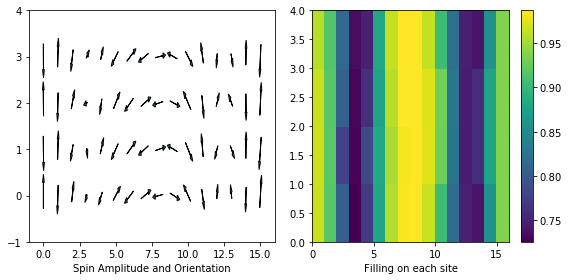

100
0.47319716091067454


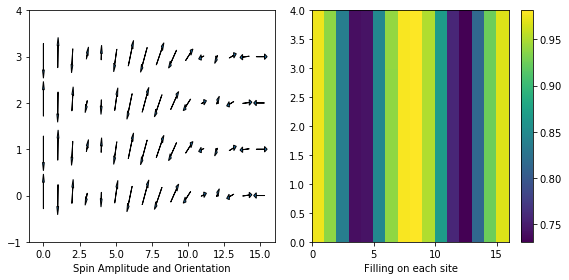

200
0.4723973146089067


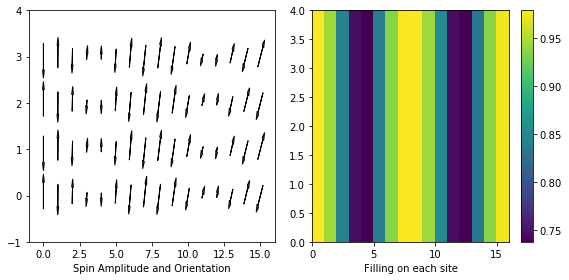

300
0.4721888576646204


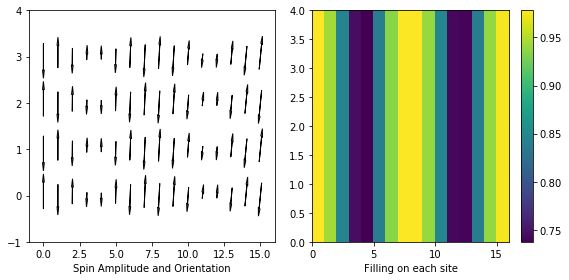

400
0.4721621651129201


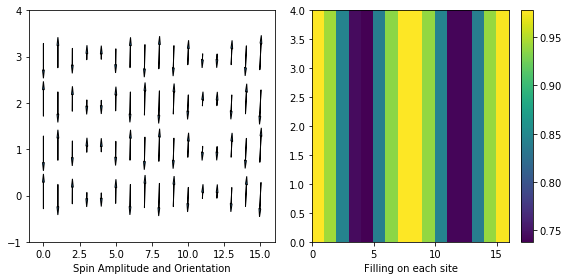

500
0.47216566531616855


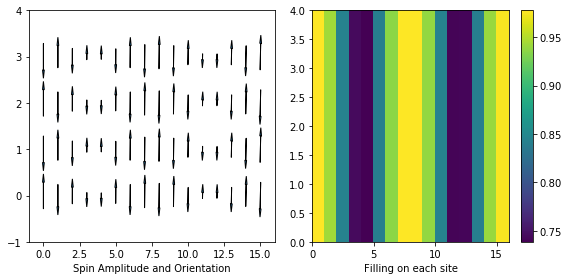

KeyboardInterrupt: 

In [123]:
for i in range(6000):
    if(i%100 == 0 or i == 20):
        print(i)
        Plot_Arrows(GapVector)
        
    Mixing = 0.3*np.random.random()
    GapVector = Mixing*GapVector + (1-Mixing)*Next_Gap_Vector(GapVector) 


In [ ]:
print(GapVector[:10],GapVector[N_tot:N_tot+10])
GapVector2 = Next_Gap_Vector(GapVector)
print(GapVector[:10],GapVector[N_tot:N_tot+10])
print(min(GapVector2 - GapVector))
print(Next_Gap_Vector(GapVector2,GetEnergy =True))

0.855441502345056


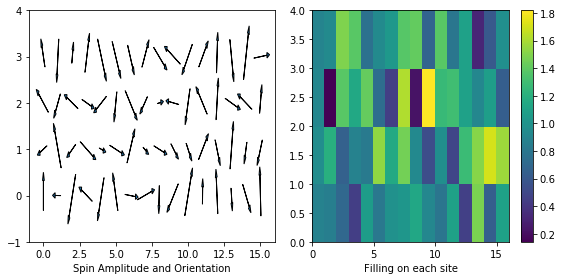

In [58]:
def Plot_Arrows(GapVector):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    Pol = N_ups-N_downs
    Pol = Pol.reshape(N_y,N_x)
    Filling = N_ups+N_downs
    Filling = Filling.reshape(N_y,N_x)

    N_is = N_ups+N_downs
    Phi_is = np.angle(D_UpDowns)
    M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)
    Theta_is = np.arccos((N_ups-N_downs)/M_is)
    #print(Theta_is)
    M_is = M_is.reshape(N_y,N_x)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for i in range(N_x):
        for j in range(N_y):

            Angle = Phi_is[N_x*j+i]-Phi_is[0] +np.pi/2
            dx = 0.8*M_is.flatten()[N_x*j+i]*np.cos(Angle)
            dy = 0.8*M_is.flatten()[N_x*j+i]*np.sin(Angle)
            axes[0].arrow(i-dx/2,j-dy/2,dx,dy,head_width = 0.12)
    axes[0].set_xlabel("Spin Amplitude and Orientation")
    axes[0].set_xlim(-1,N_x)
    axes[0].set_ylim(-1,N_y)

    #print(Phi_is/np.pi)
    #print((Phi_is[1]-Phi_is[0])/(np.pi),(Phi_is[2]-Phi_is[1])/(np.pi),(Phi_is[3]-Phi_is[2])/(np.pi))
    print(np.mean(M_is.flatten()))

    im = axes[1].pcolormesh(Filling)
    axes[1].set_xlabel("Filling on each site")
    fig.tight_layout()
    #cax = fig.add_axes([0.99, 0.15, 0.02, 0.8])
    fig.colorbar(im,orientation='vertical')
    
    ###plt.savefig("N_18_20_U4_1over9Doping.pdf",format="pdf")
    plt.show()

Plot_Arrows(GapVector)

0
0.7730773930278338


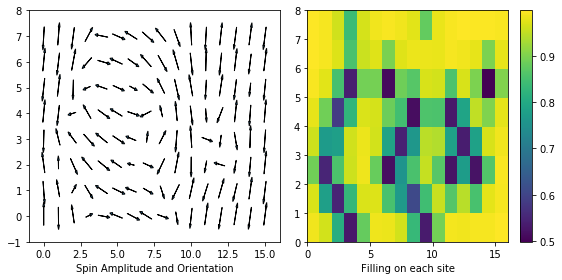

20
0.7730783651315294


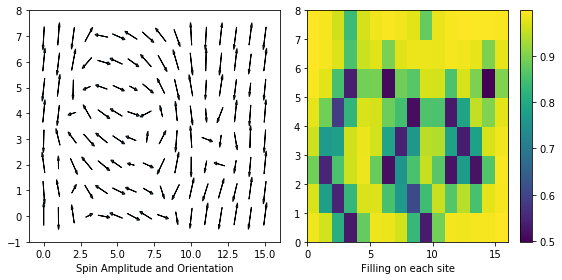

100
0.7730822677575656


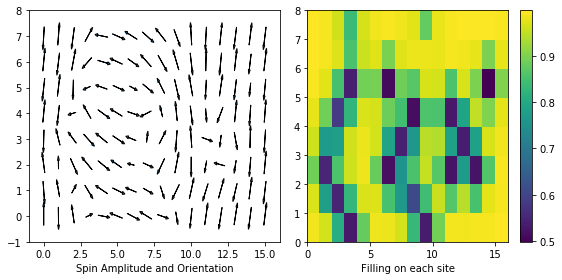

200
0.7730871767312848


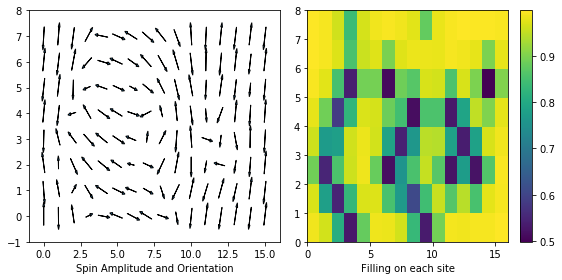

300
0.773091999634773


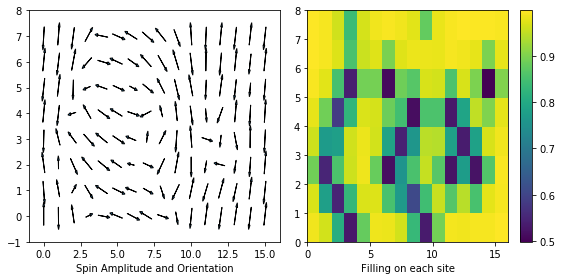

400
0.7730967559851168


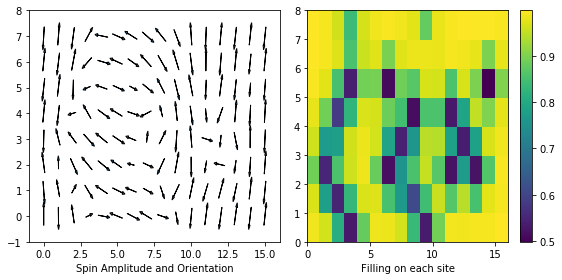

500
0.7731013875428485


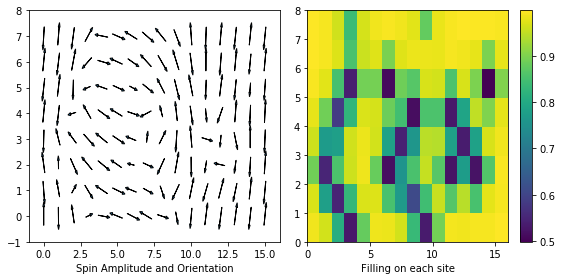

600
0.773105823161743


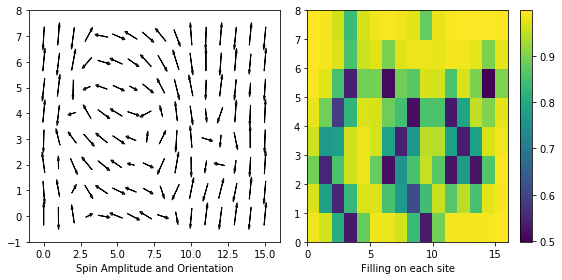

700
0.7731100794801423


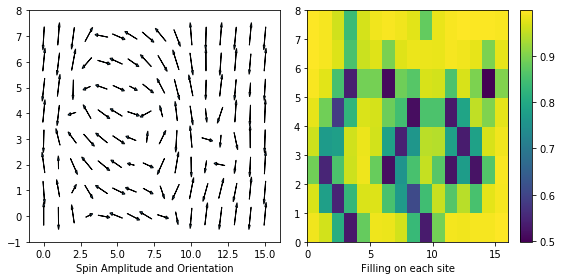

800
0.7731142024026534


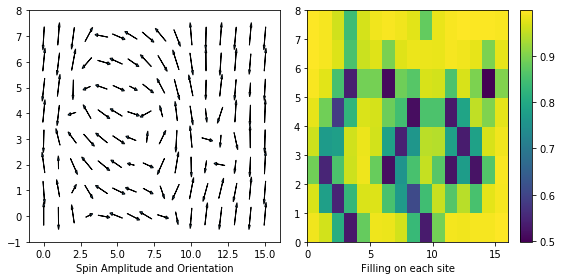

900
0.7731180915617746


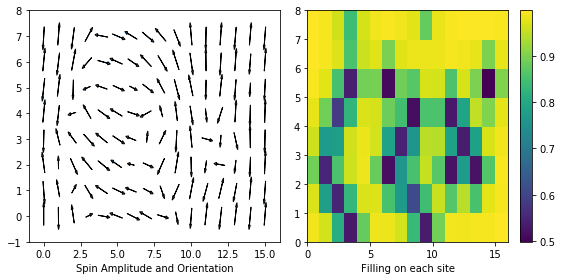

1000
0.7731218479362338


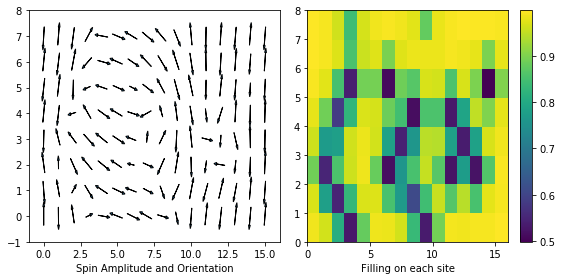

1100
0.7731254687723425


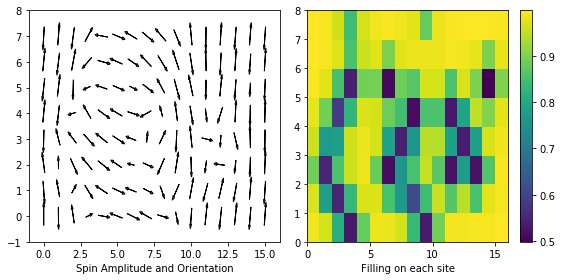

1200
0.7731288653996782


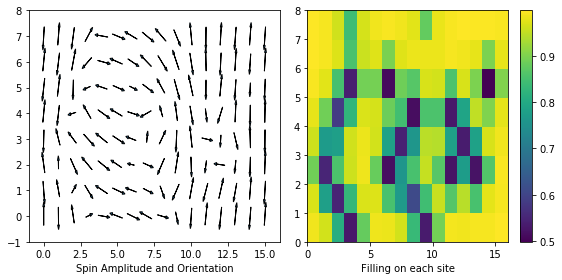

1300
0.7731320384956564


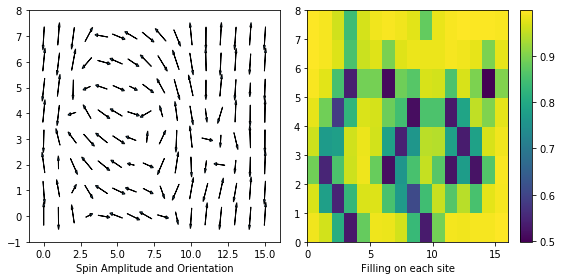

1400
0.7731350993681467


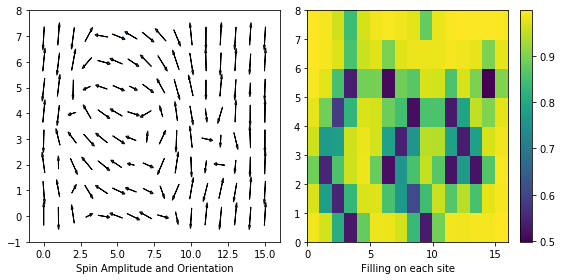

1500
0.7731380326374793


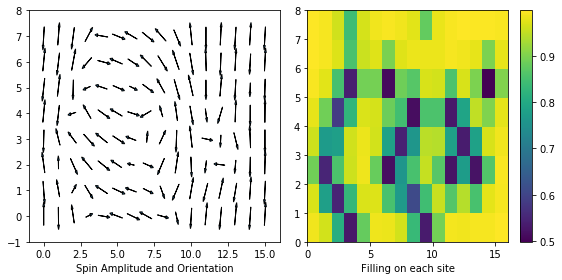

1600
0.7731407854671322


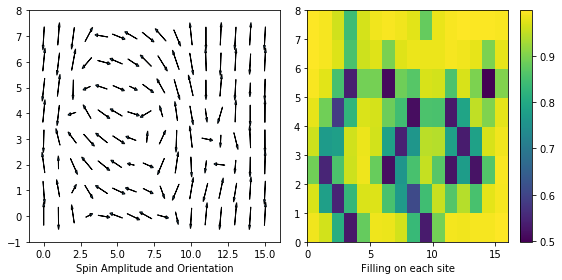

1700
0.7731433839936475


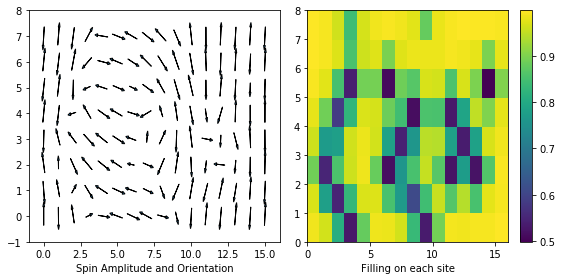

1800
0.773145840388817


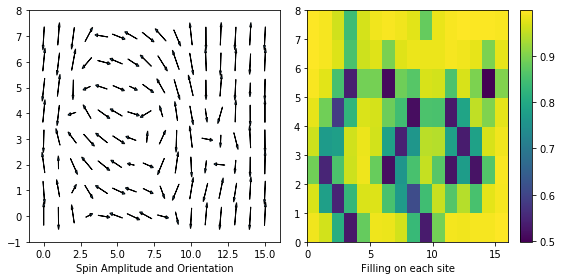

1900
0.7731481636434698


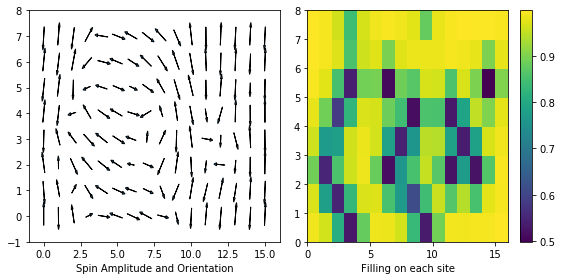

2000
0.7731503419243249


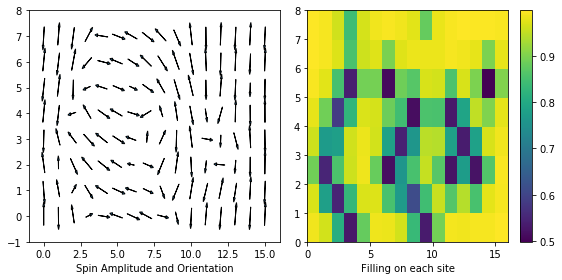

2100
0.7731524127143087


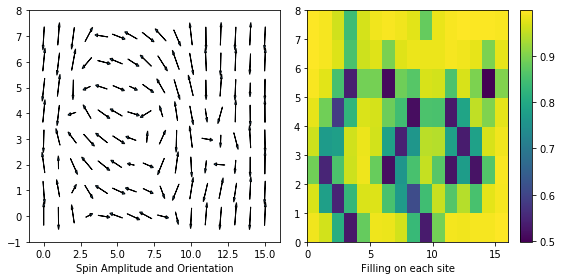

2200
0.7731543572750514


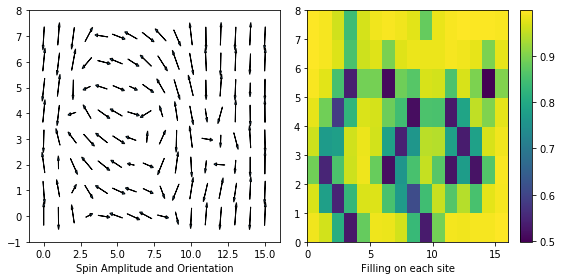

2300
0.7731561962778564


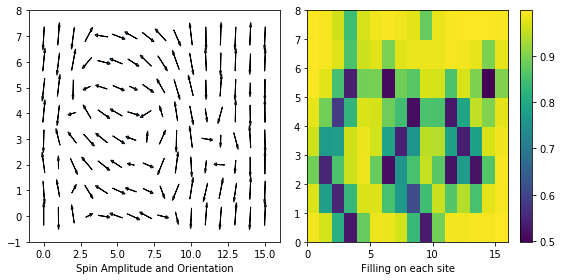

2400
0.7731579548093757


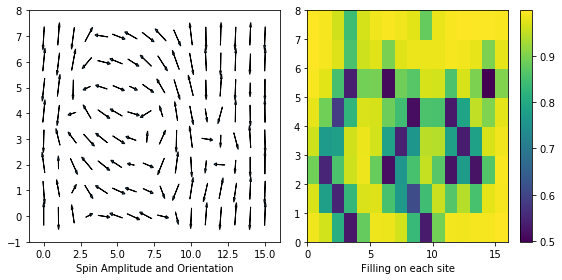

2500
0.7731596063795476


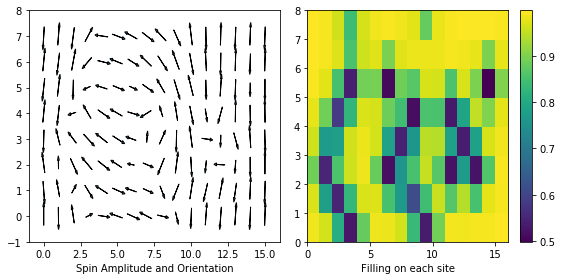

2600
0.7731611751567533


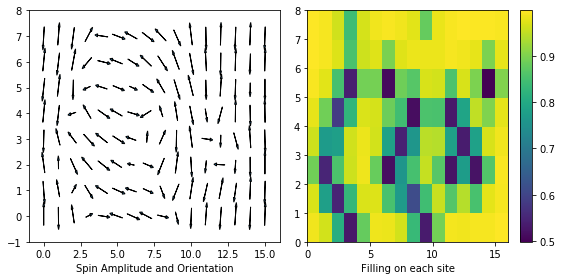

2700
0.7731626110975259


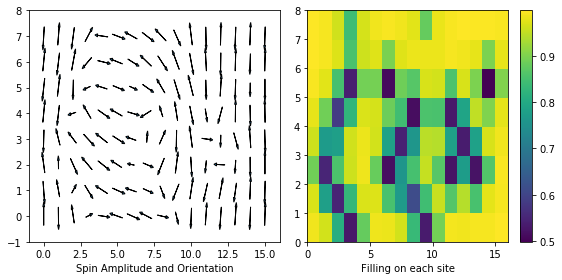

2800
0.7731640140785898


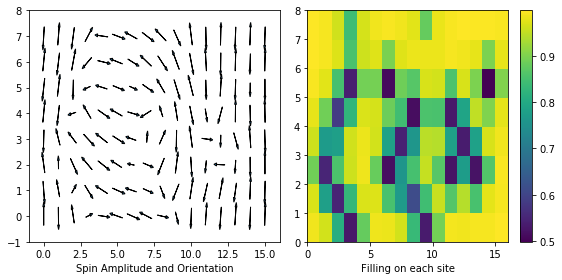

2900
0.7731653077146068


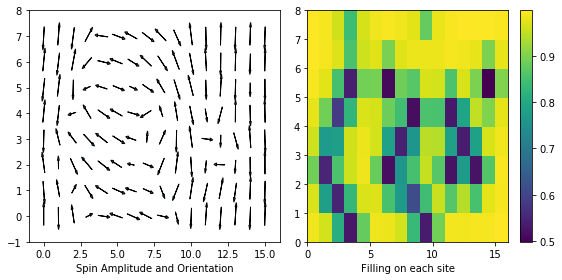

3000
0.7731665334966085


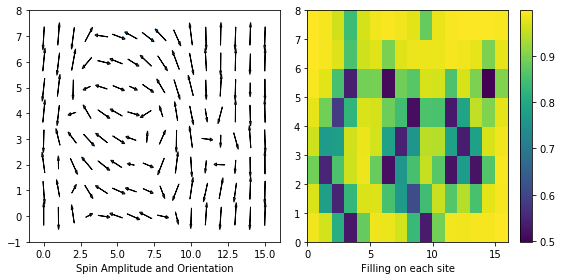

3100
0.7731677061649465


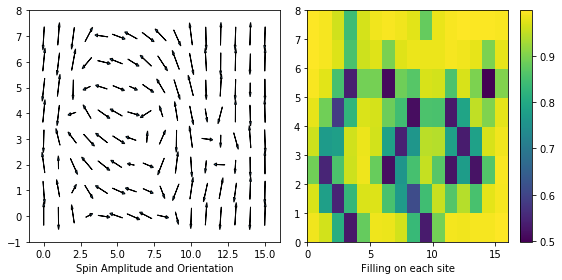

3200
0.7731688005694696


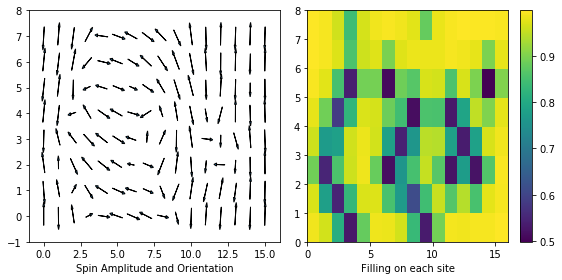

3300
0.7731698547079875


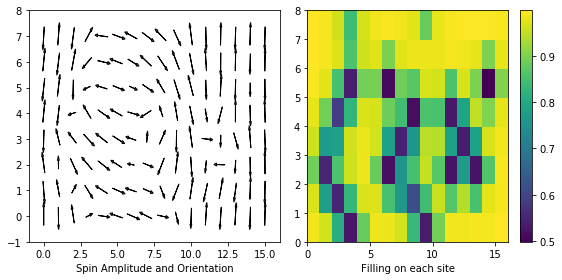

3400
0.7731708435229697


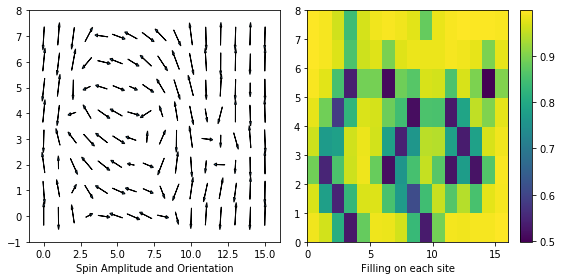

3500
0.7731717652323052


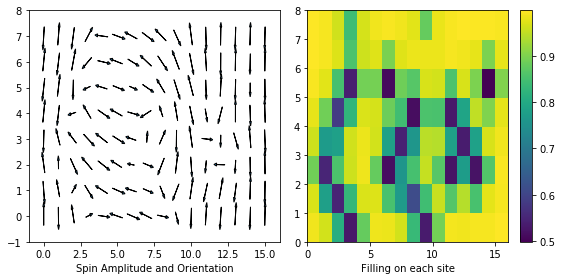

3600
0.7731726283224136


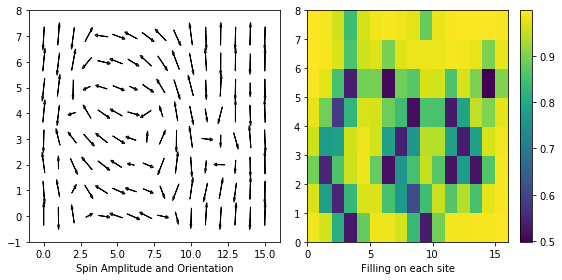

3700
0.7731734474727665


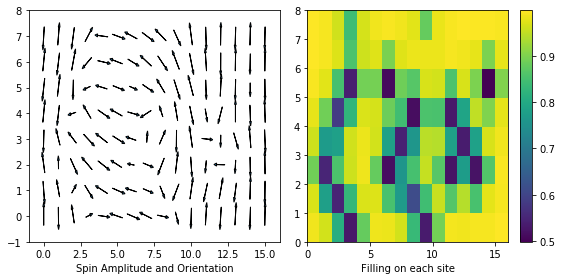

3800
0.7731742077663022


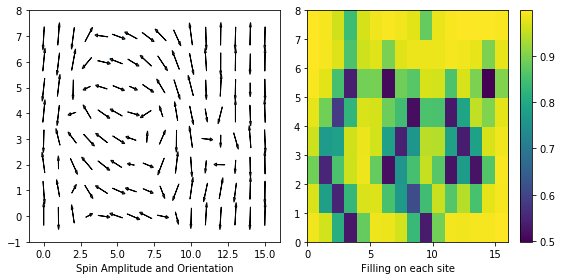

3900
0.7731749240825585


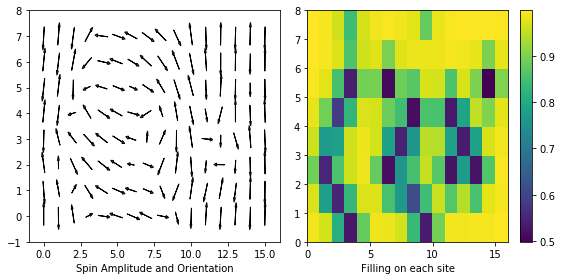

4000
0.7731756113643218


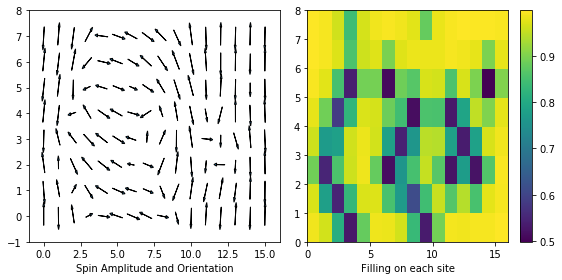

4100
0.7731762461355383


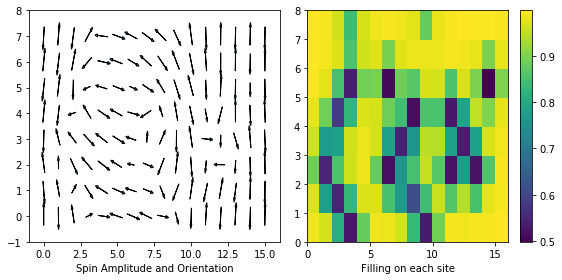

4200
0.773176855968388


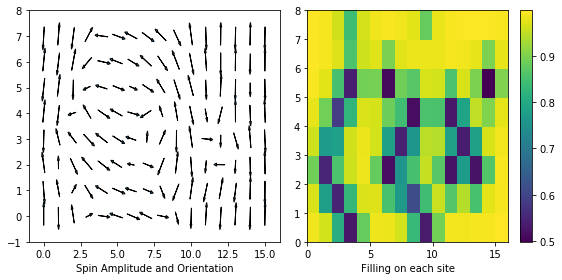

4300
0.7731774248624607


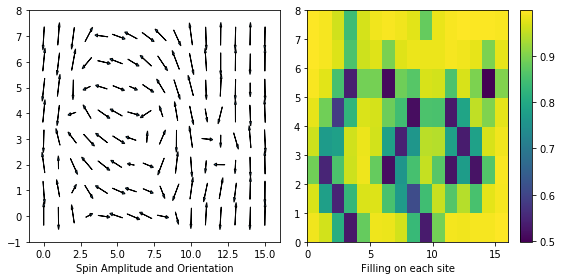

4400
0.7731779651974424


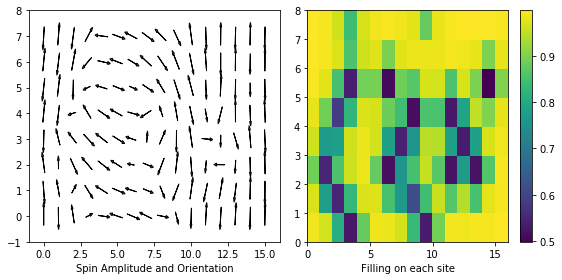

4500
0.77317847633849


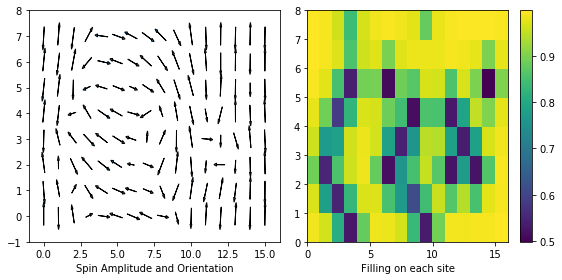

4600
0.773178961127212


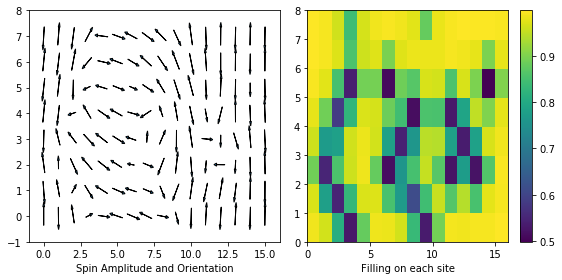

4700
0.7731794085810535


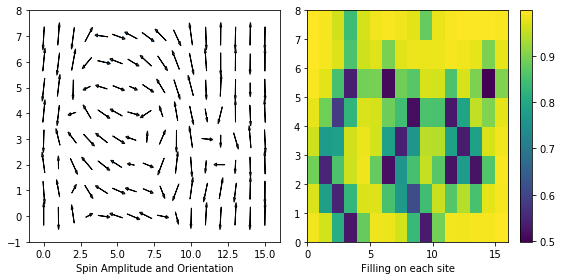

4800
0.77317983644073


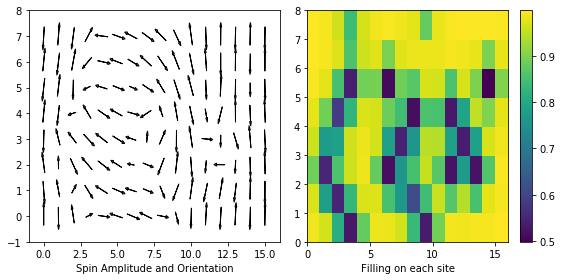

4900
0.7731802430457948


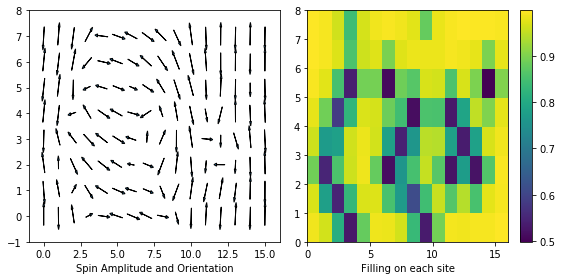

5000
0.7731806221882385


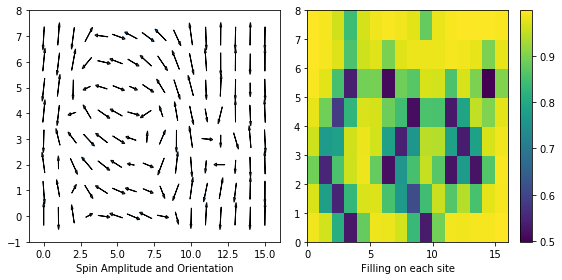

5100
0.7731809787770164


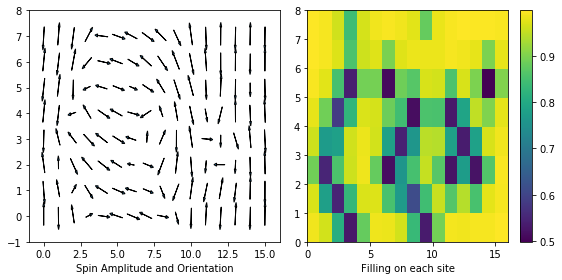

5200
0.7731813144688546


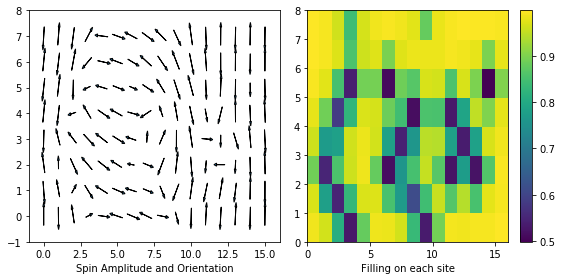

5300
0.7731816281795505


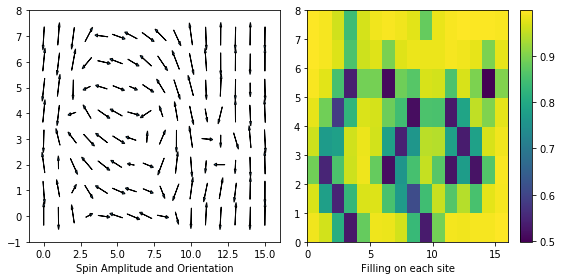

5400
0.7731819304791081


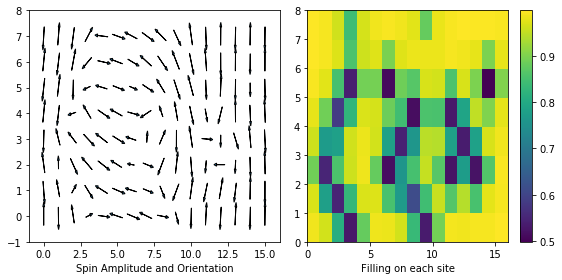

5500
0.7731822086165212


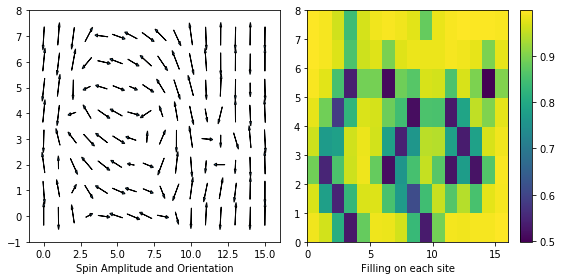

5600
0.7731824814632129


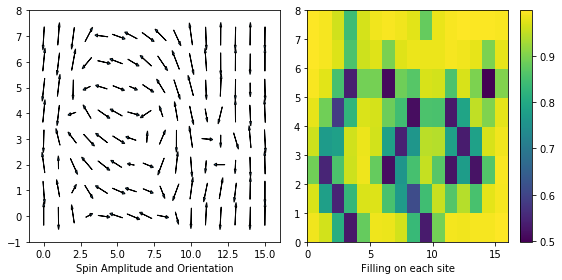

5700
0.7731827325029343


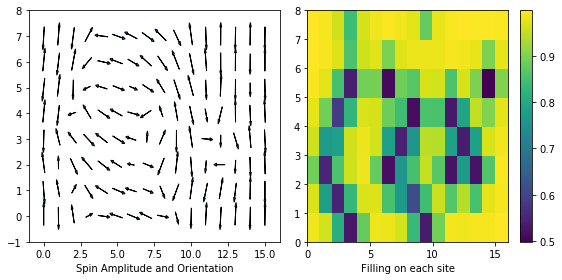

5800
0.7731829718656966


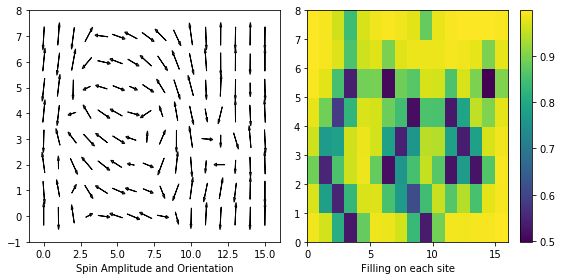

5900
0.7731831965648868


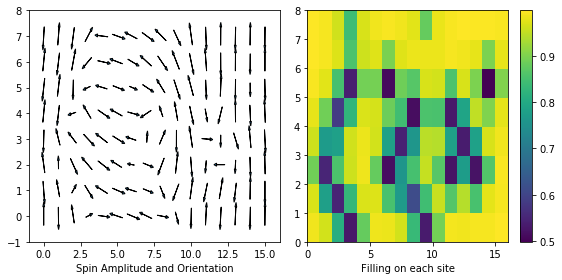

6000
0.7731834076203978


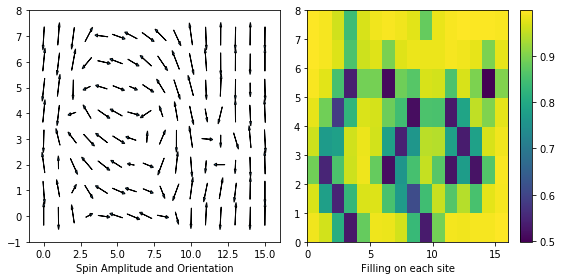

6100
0.7731836030063566


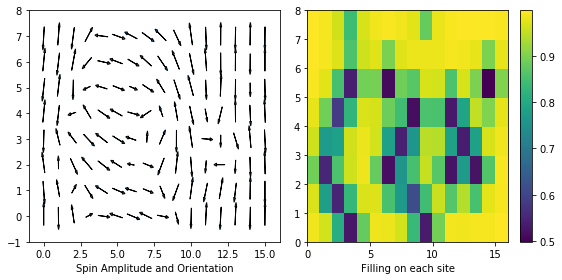

6200
0.773183791133883


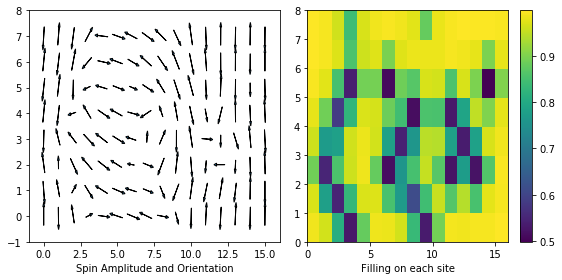

6300
0.7731839681166719


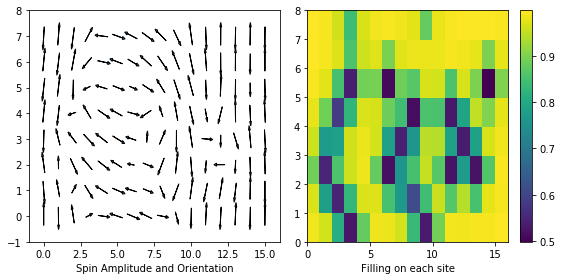

6400
0.7731841313756856


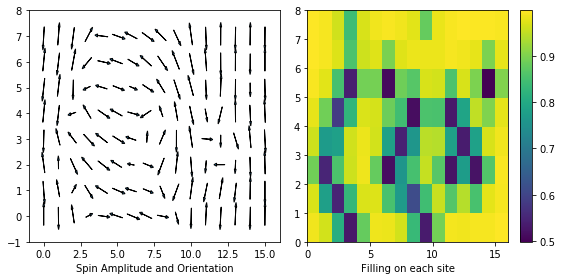

6500
0.7731842887285669


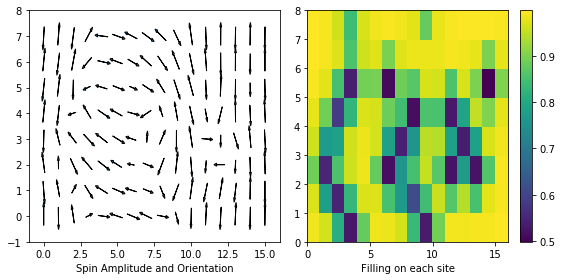

6600
0.7731844346214798


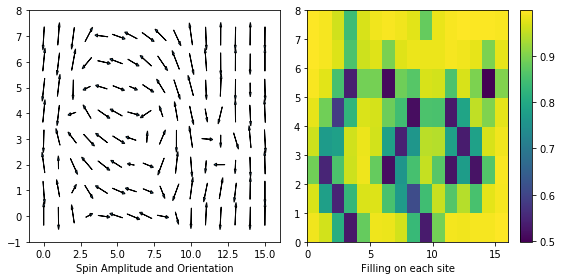

6700
0.7731845735865841


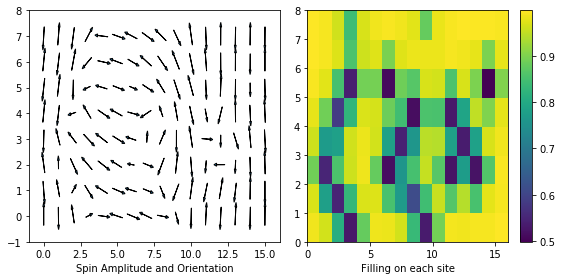

6800
0.7731847063836599


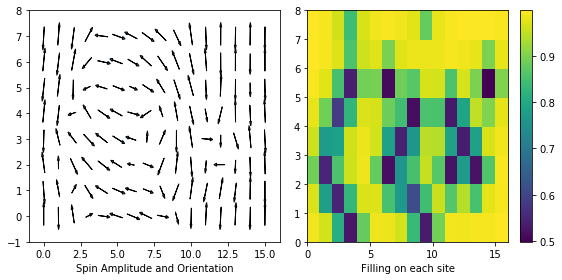

6900
0.7731848328500371


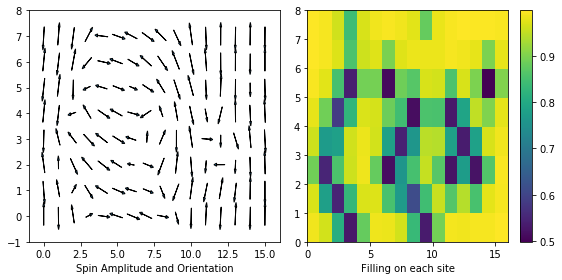

7000
0.7731849496663431


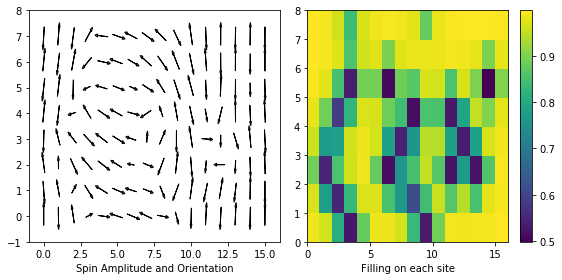

7100
0.7731850592823004


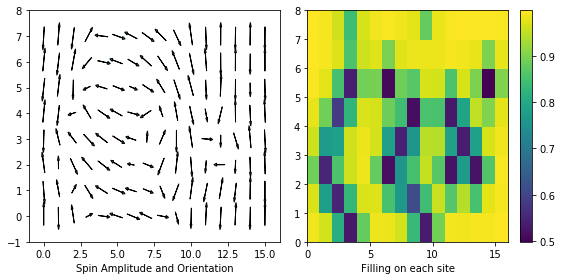

7200
0.773185163480067


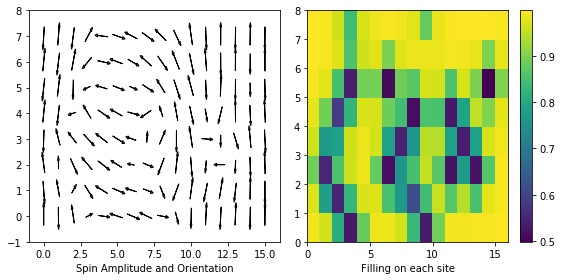

7300
0.7731852607794727


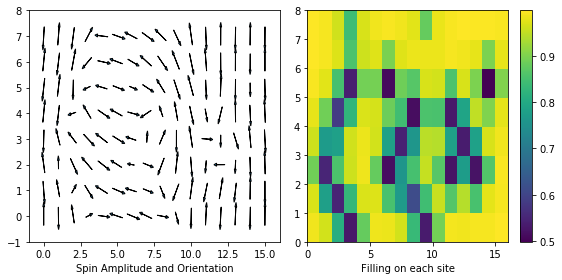

7400
0.7731853529362258


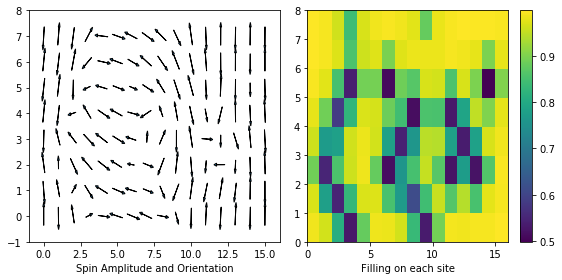

7500
0.7731854389571176


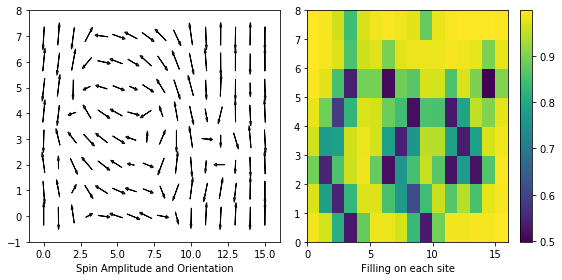

7600
0.7731855211203483


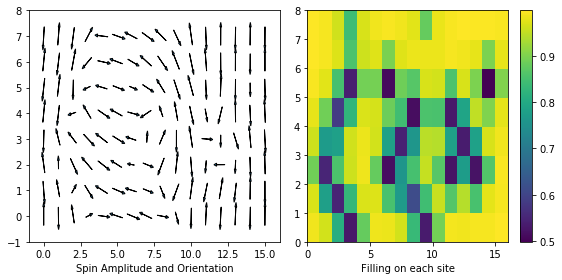

7700
0.7731855988862617


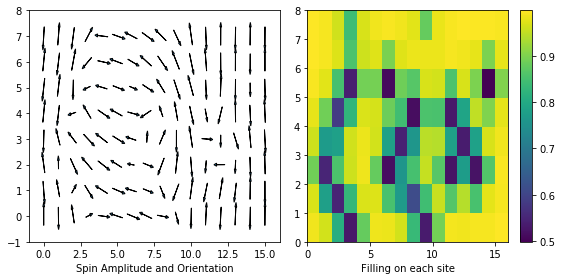

7800
0.7731856729294998


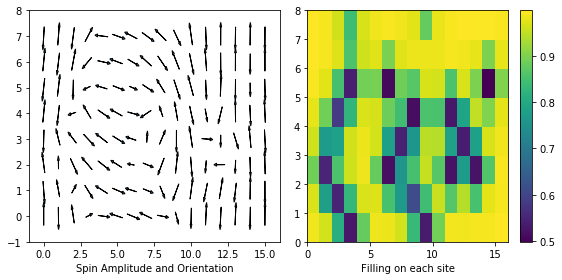

7900
0.7731857437455366


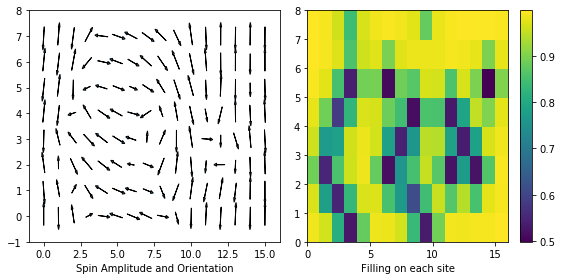

8000
0.7731858077759614


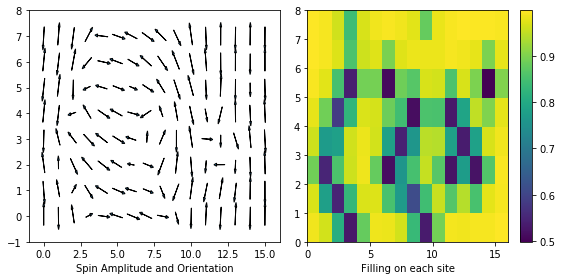

8100
0.773185869104983


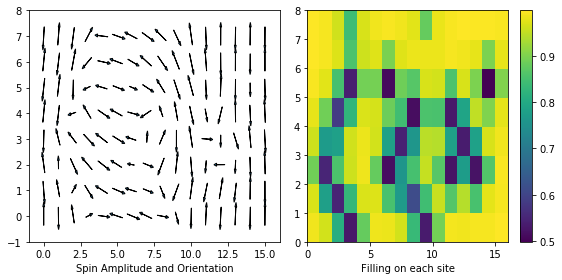

8200
0.773185926046328


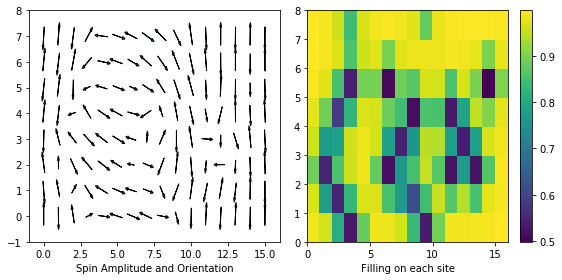

8300
0.7731859813280142


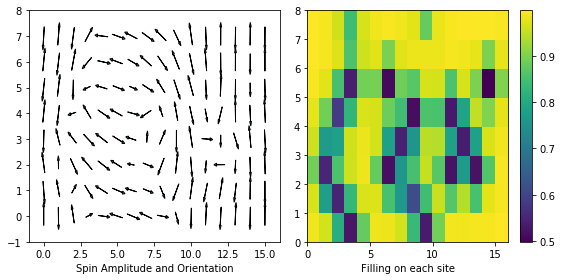

8400
0.7731860326401573


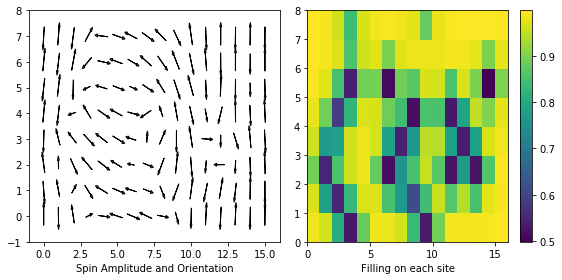

8500
0.7731860820264399


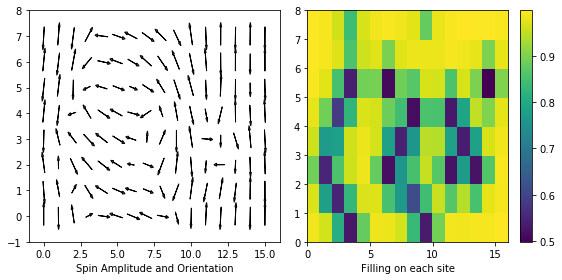

8600
0.7731861276738154


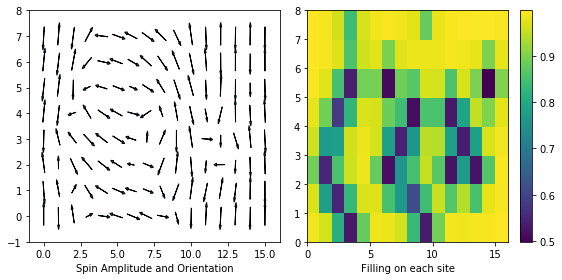

8700
0.7731861715278879


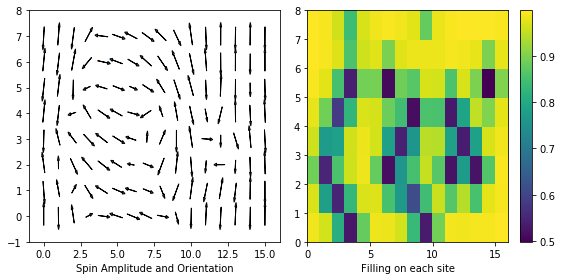

8800
0.7731862123339521


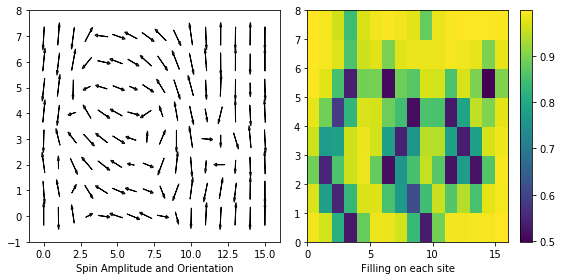

8900
0.7731862510995335


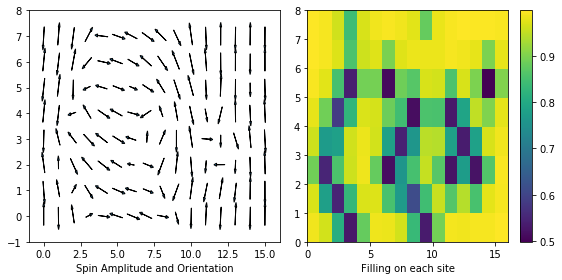

9000
0.7731862874626964


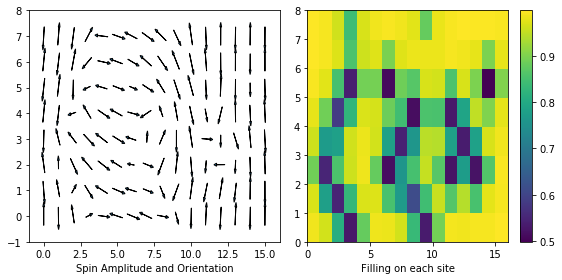

9100
0.7731863209417473


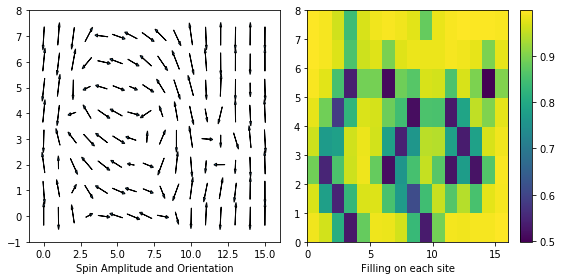

9200
0.7731863531344243


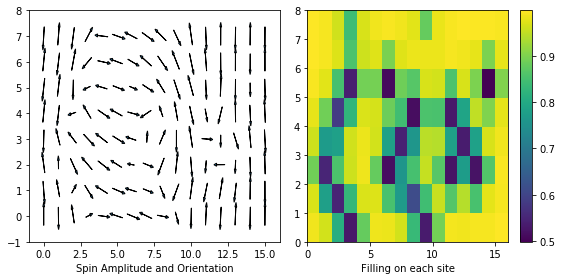

9300
0.7731863830073838


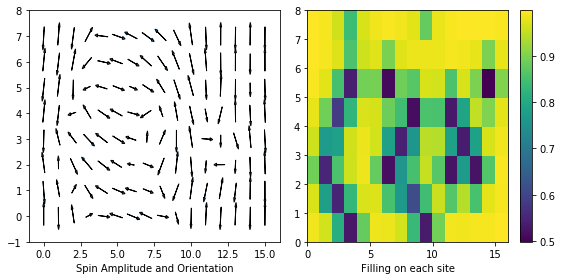

9400
0.7731864102432564


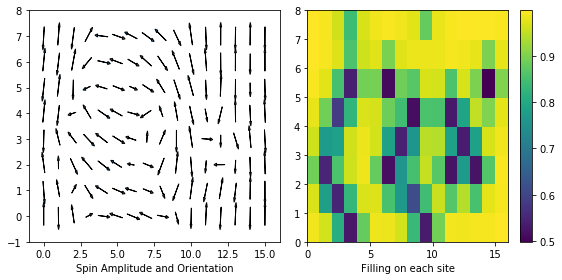

9500
0.7731864355937177


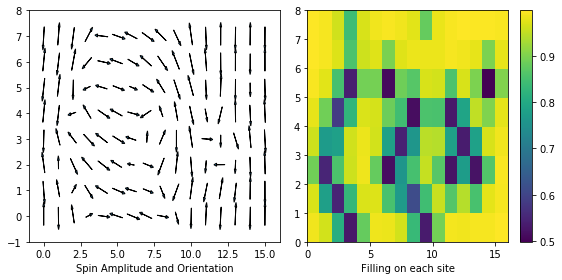

9600
0.7731864585567785


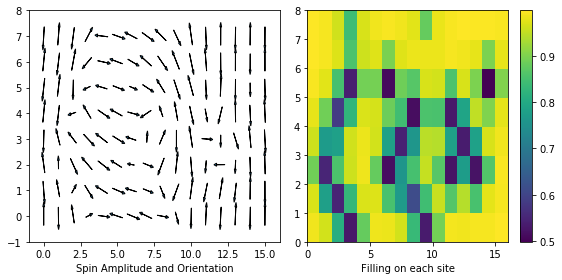

9700
0.7731864787591722


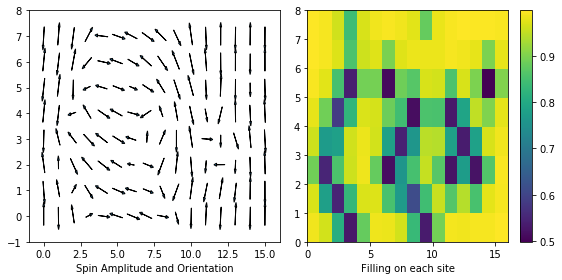

9800
0.7731864956026999


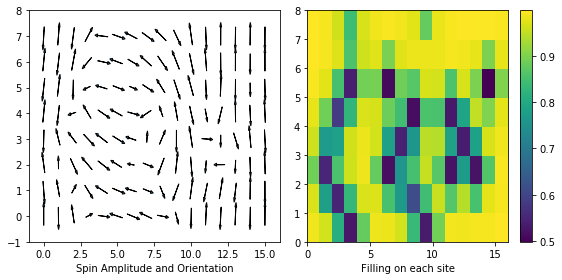

9900
0.7731865084444478


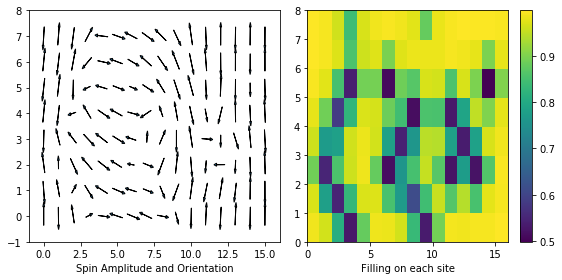

10000
0.7731865150941295


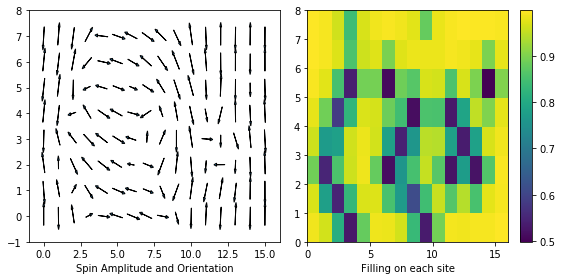

10100
0.7731865125157417


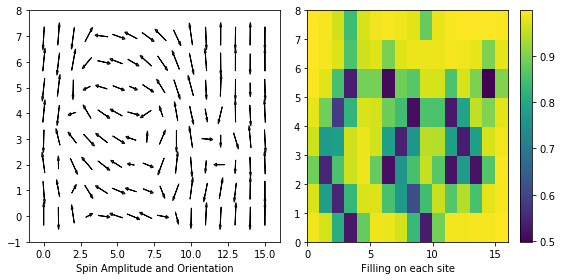

10200
0.7731864964459783


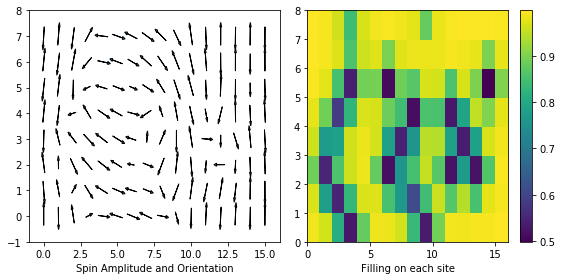

10300
0.7731864592818236


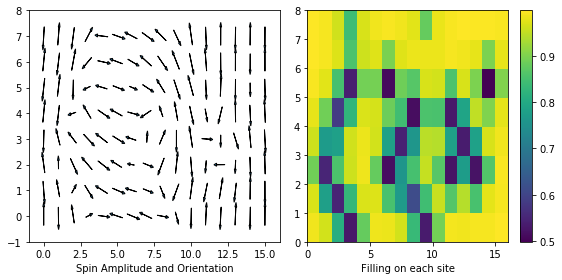

10400
0.7731863914028211


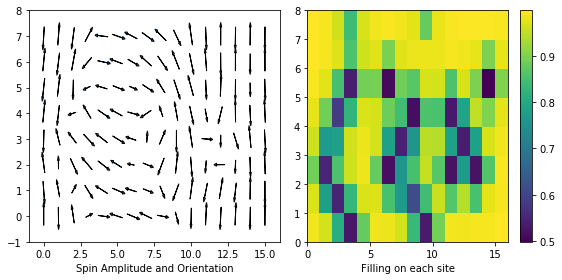

10500
0.7731862727387115


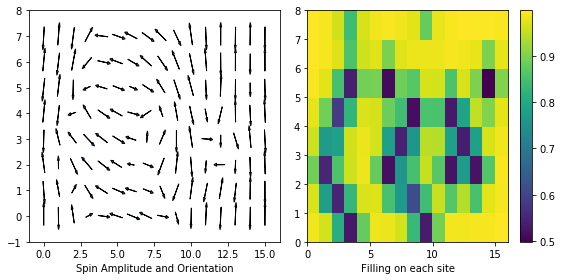

10600
0.7731860786971609


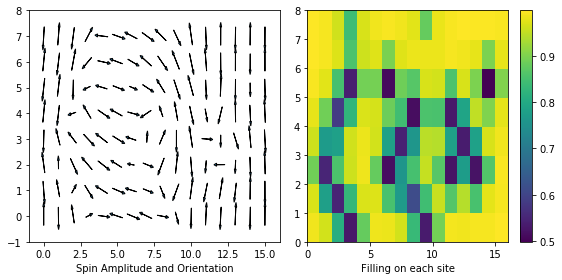

10700
0.7731857613557538


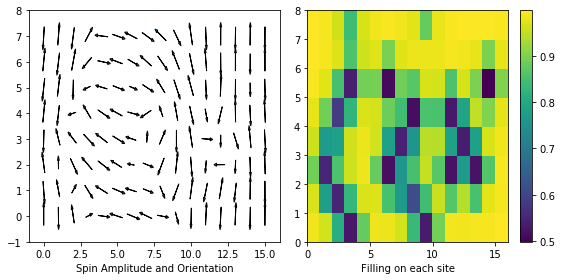

10800
0.7731852519870543


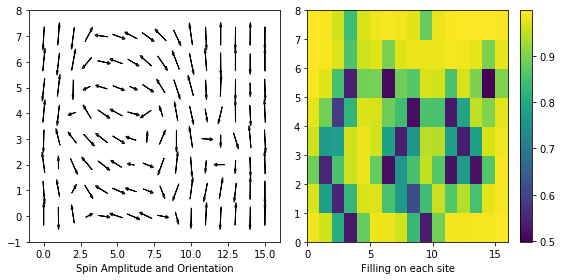

10900
0.7731844513673647


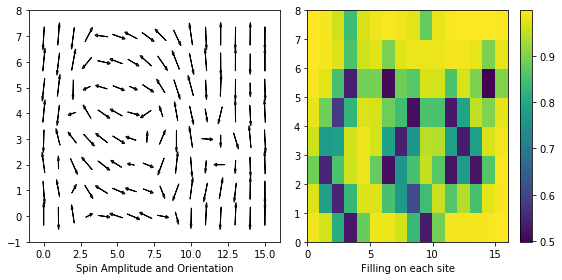

11000
0.7731831799953625


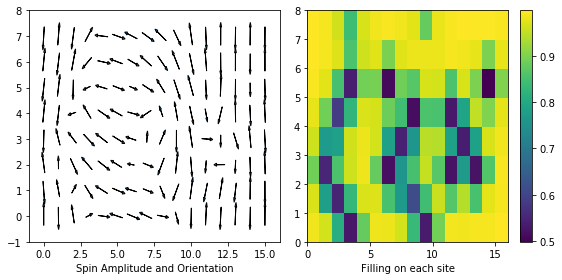

11100
0.773181209511582


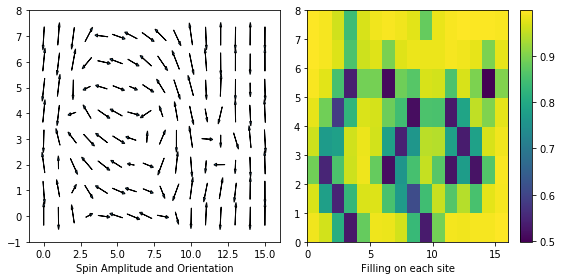

11200
0.7731781100985466


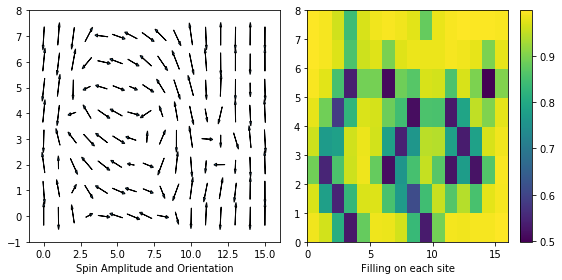

11300
0.7731732369175668


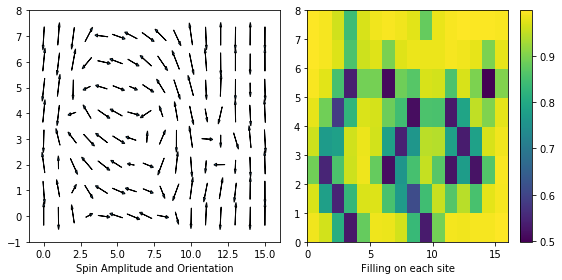

11400
0.7731659029290536


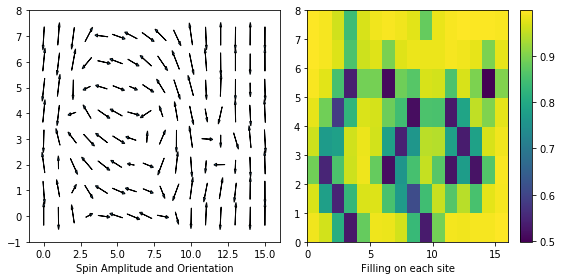

11500
0.7731546078490166


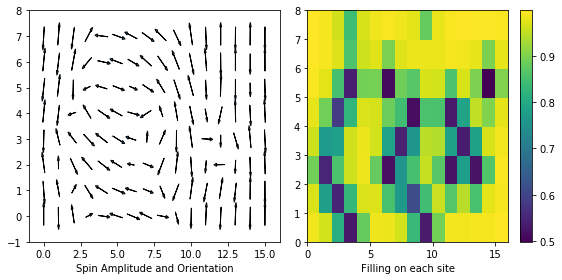

11600
0.77313783842864


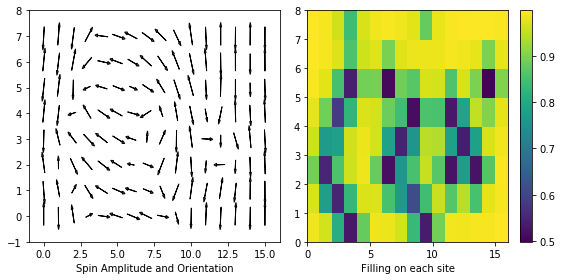

11700
0.7731141115839546


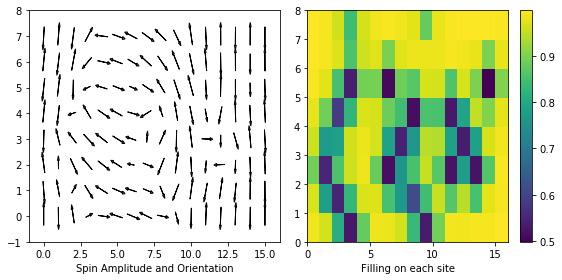

11800
0.7730802025291419


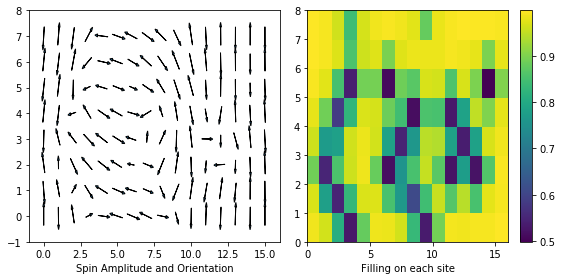

11900
0.7730372952534599


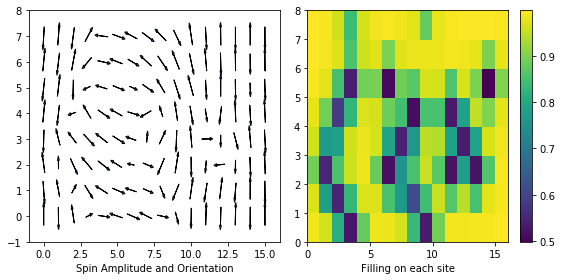

12000
0.7729854872237625


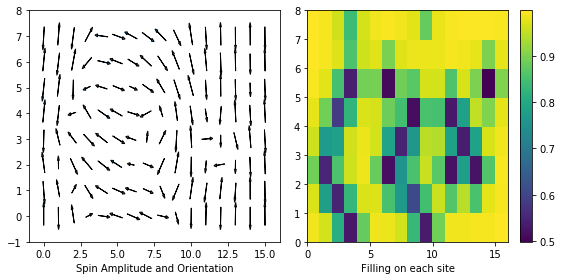

12100
0.7729274253507269


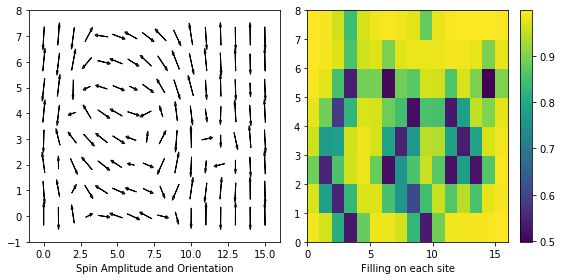

12200
0.7728682240145288


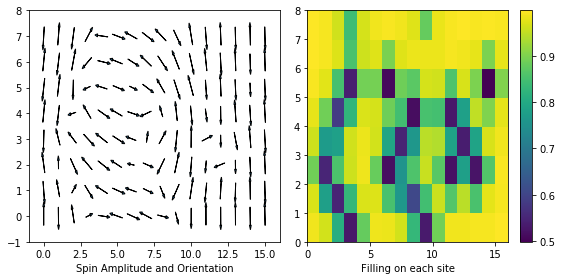

12300
0.7728098746560074


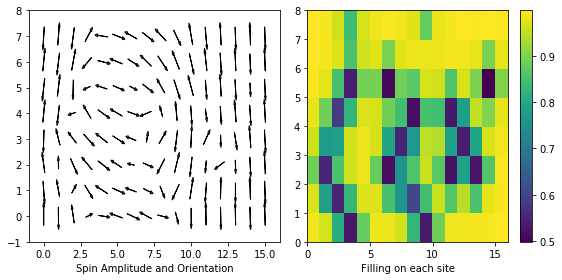

12400
0.7727573392537834


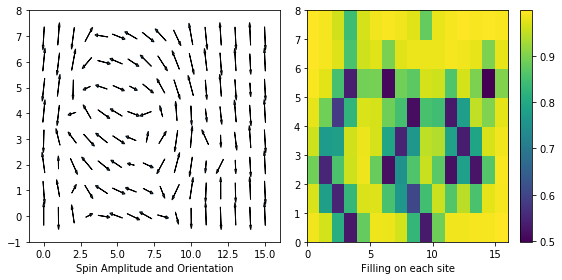

12500
0.7727112962127094


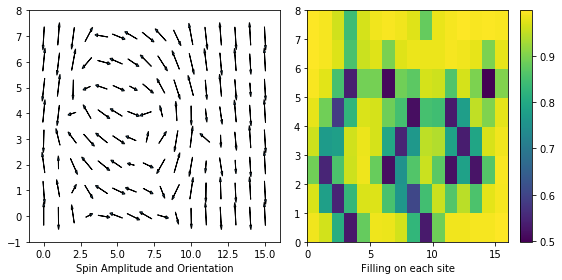

12600
0.772673640002496


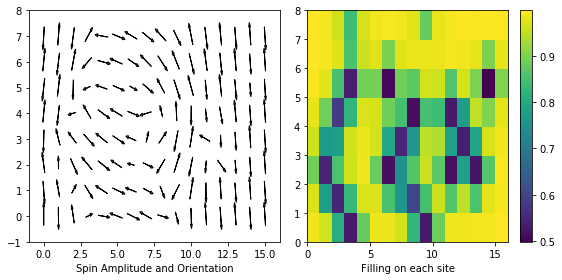

12700
0.7726438173771584


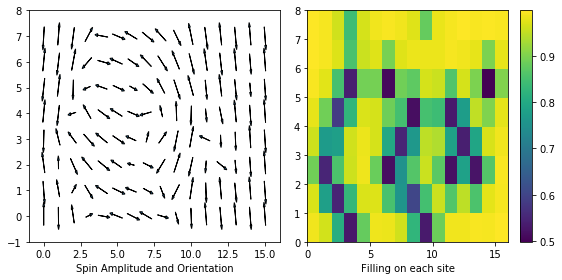

12800
0.7726198391906991


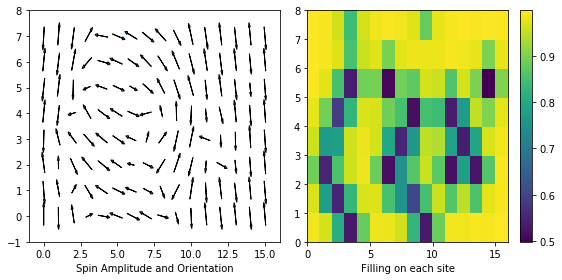

12900
0.7726011915007462


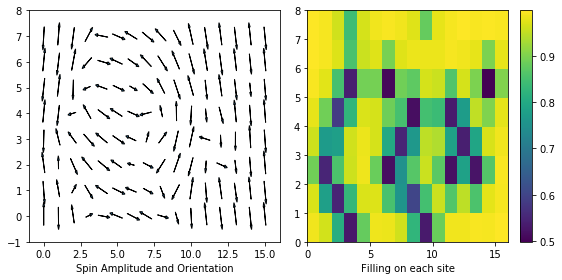

13000
0.7725872821437183


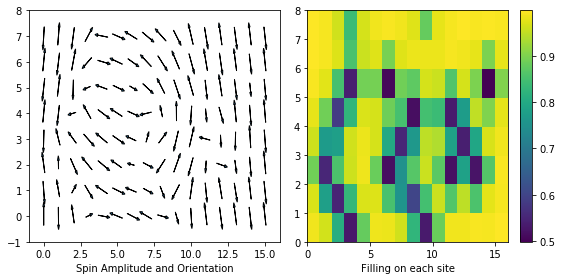

13100
0.7725769768142864


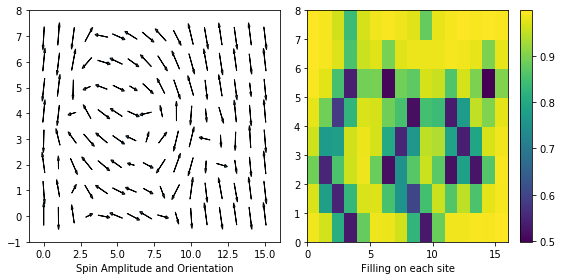

13200
0.7725695025564288


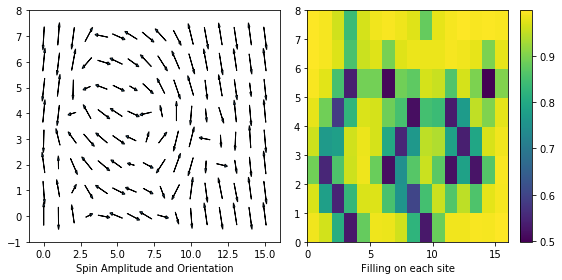

13300
0.772564416991621


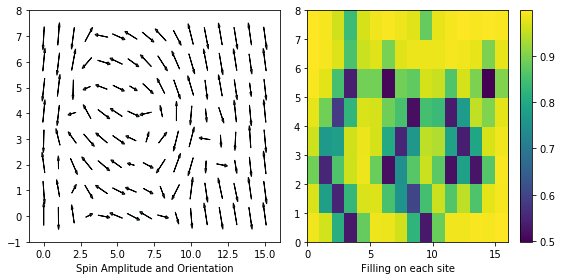

13400
0.7725611301593263


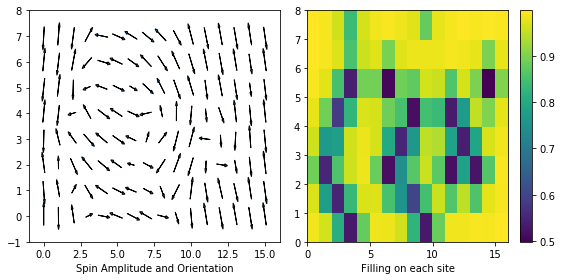

13500
0.7725592346709558


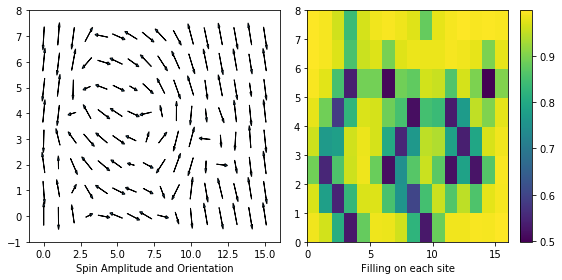

13600
0.7725585011993563


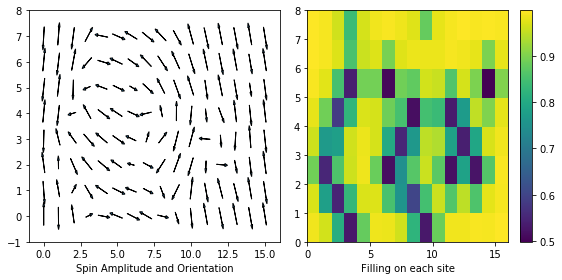

13700
0.772558649809804


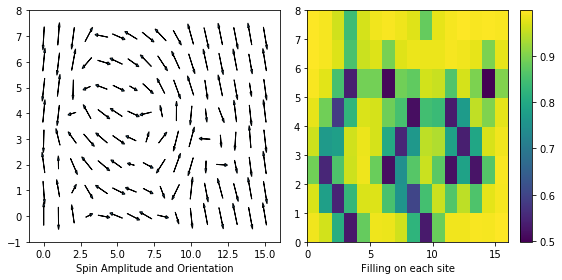

13800
0.7725594529109809


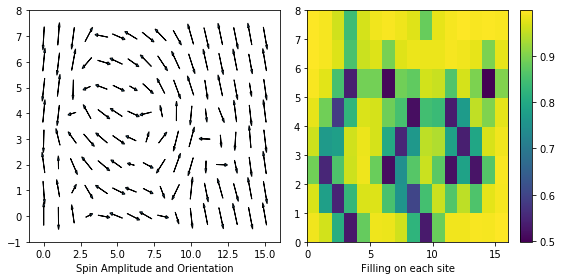

13900
0.7725607779301078


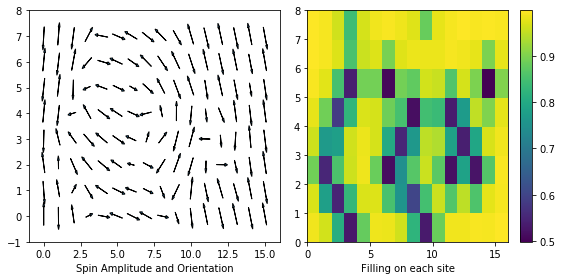

14000
0.772562468688875


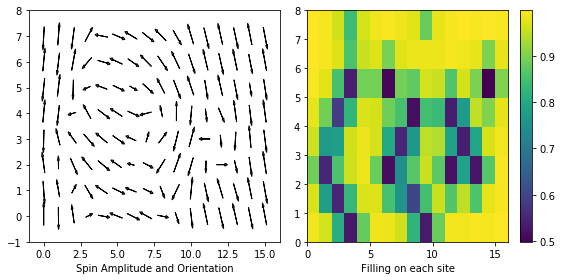

14100
0.7725644330386652


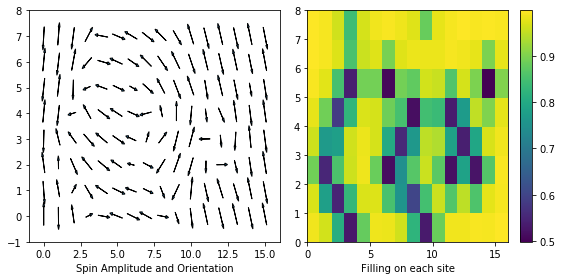

14200
0.7725665881900379


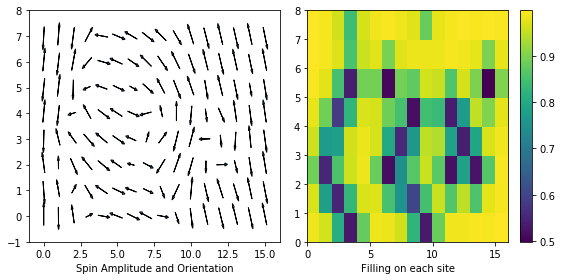

14300
0.7725689132194334


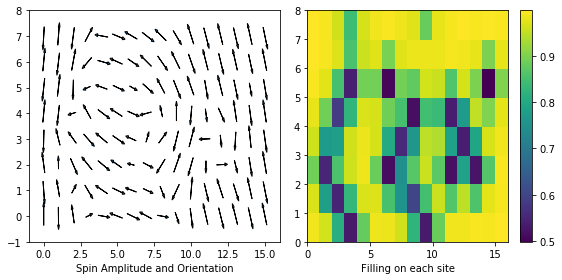

14400
0.7725712265002123


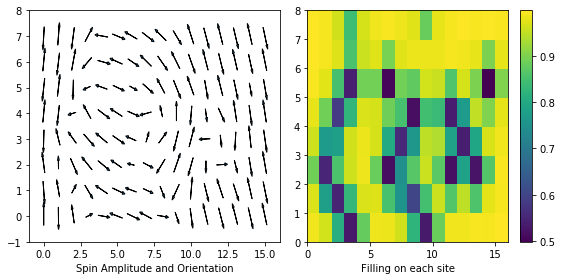

14500
0.7725736100626931


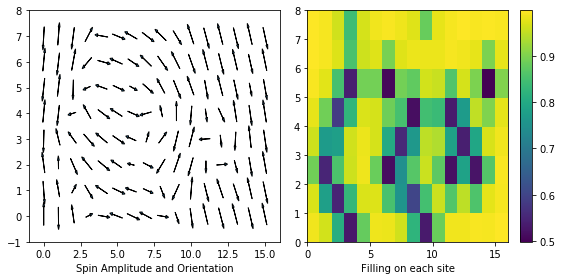

14600
0.7725759974922208


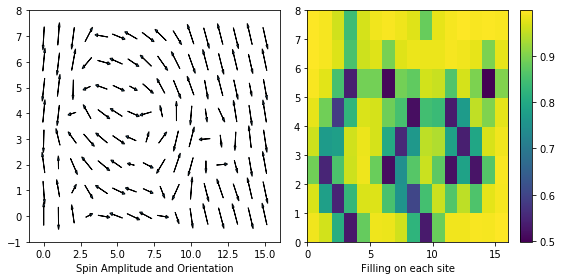

14700
0.7725783266895806


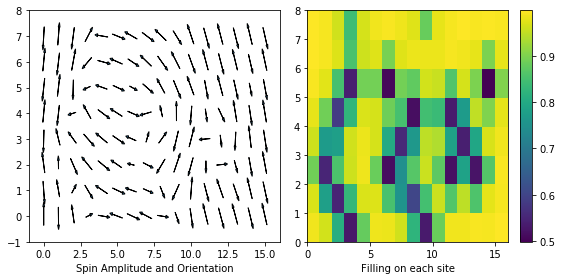

14800
0.7725806798049502


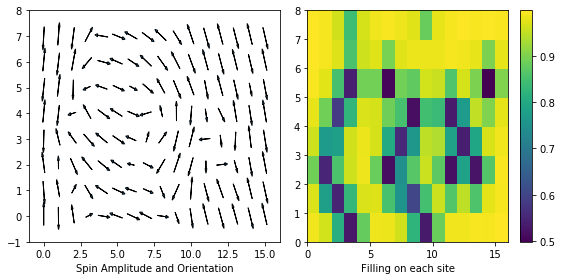

14900
0.7725829235450024


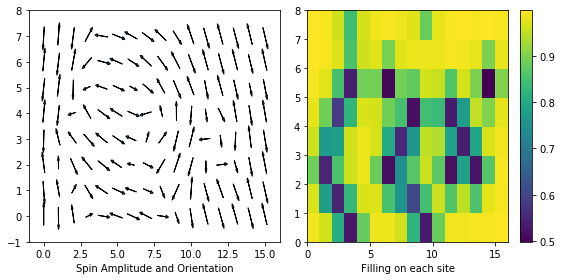

15000
0.772585202570347


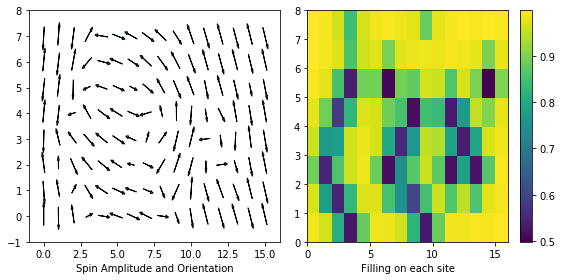

15100
0.7725873028651254


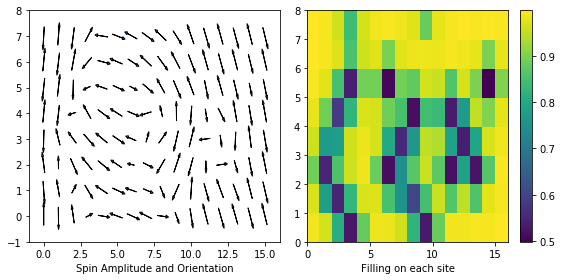

15200
0.7725894161154503


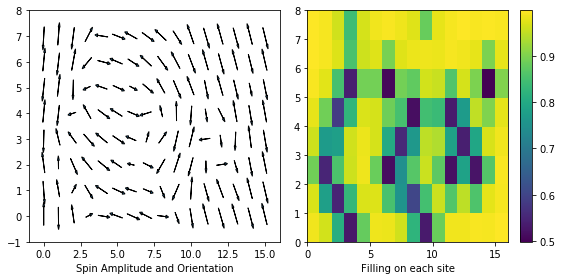

15300
0.7725913710921429


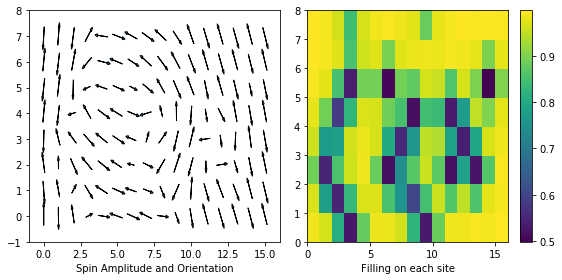

15400
0.7725932680053104


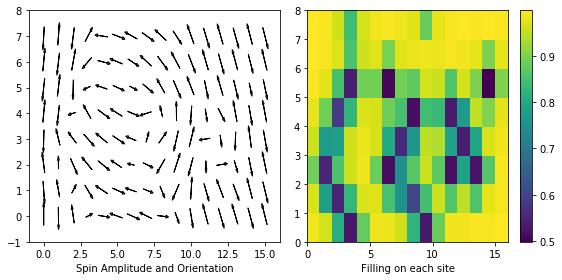

15500
0.7725950976676568


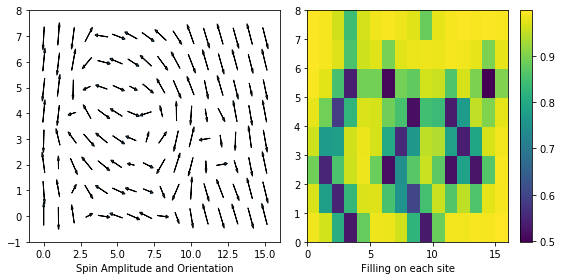

15600
0.7725968533116621


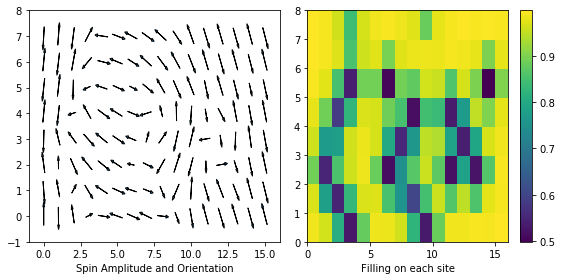

15700
0.7725984739158518


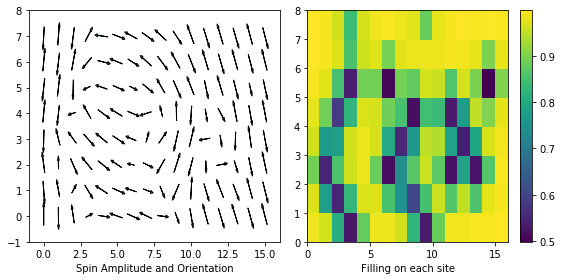

15800
0.7726000148442548


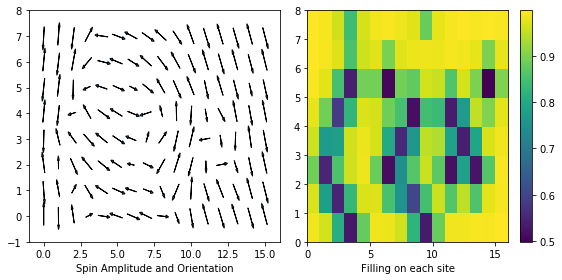

15900
0.7726014998514685


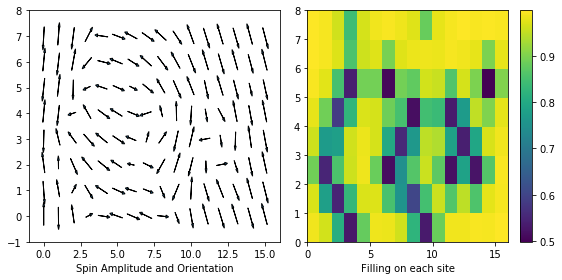

16000
0.772602911990426


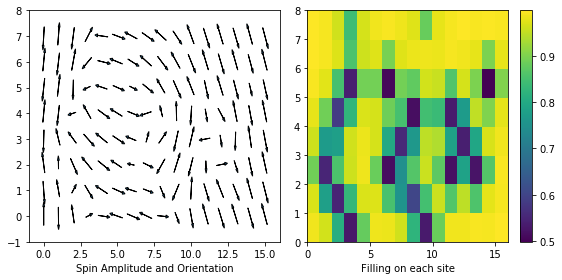

16100
0.7726042554139949


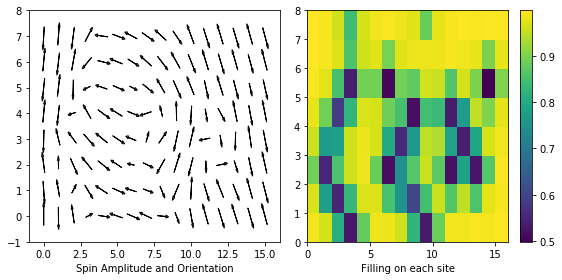

16200
0.7726055190144305


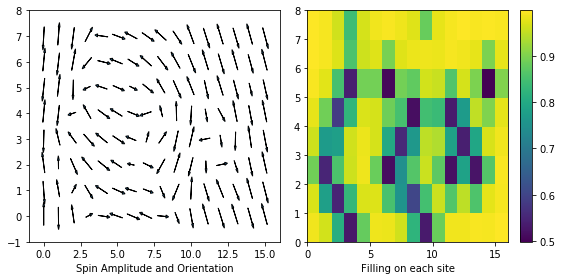

16300
0.7726067098754806


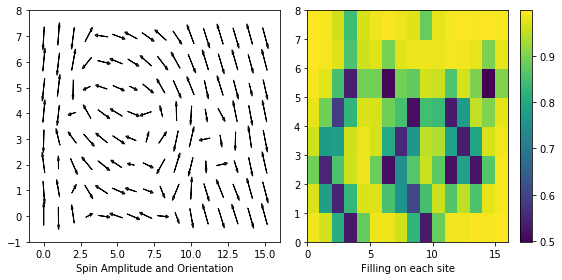

16400
0.7726078541454948


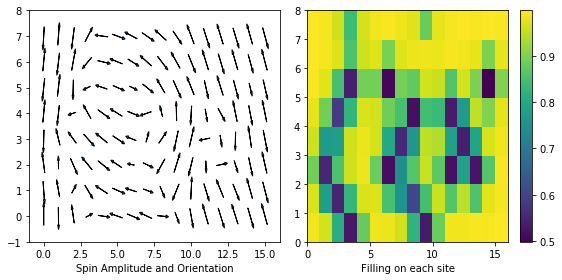

16500
0.7726089123713602


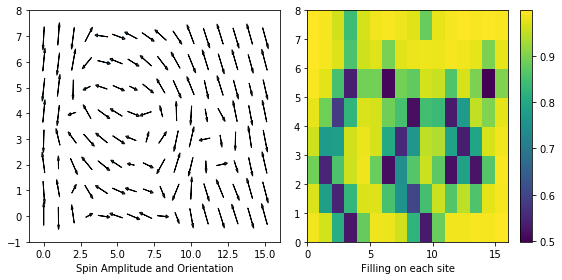

16600
0.7726099148703703


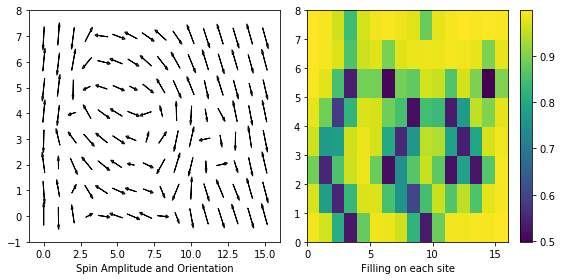

16700
0.7726108602194519


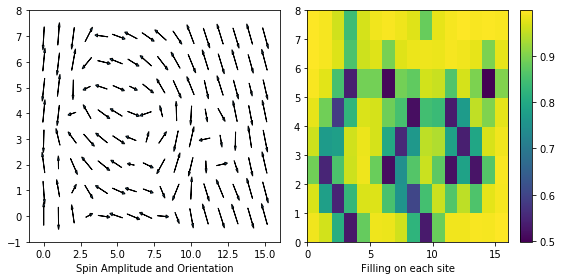

16800
0.7726117480385699


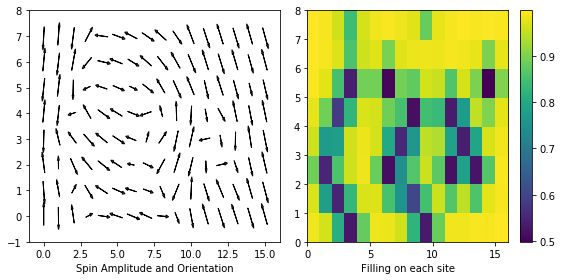

16900
0.7726126002688761


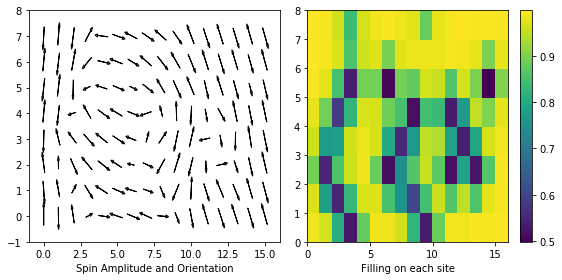

17000
0.7726133986062766


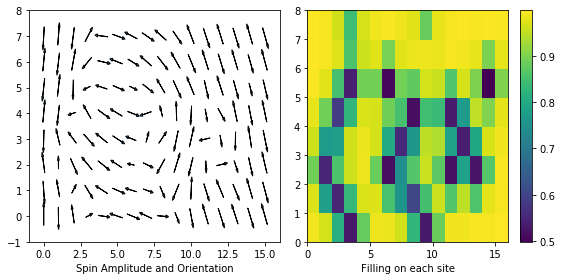

17100
0.7726141487589051


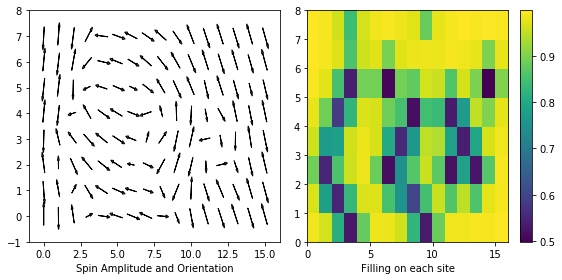

17200
0.7726148545174485


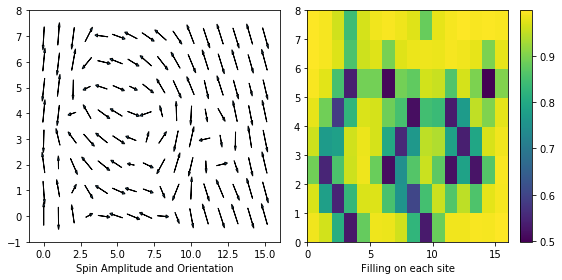

17300
0.772615522274118


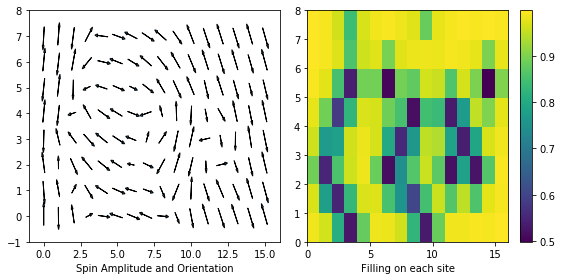

17400
0.7726161625008964


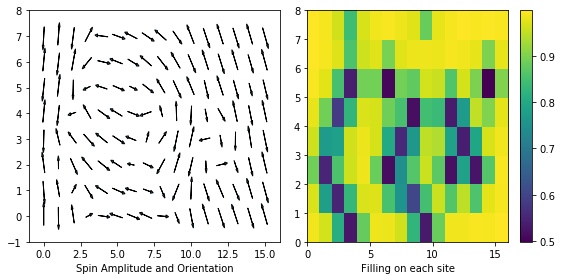

17500
0.772616761123369


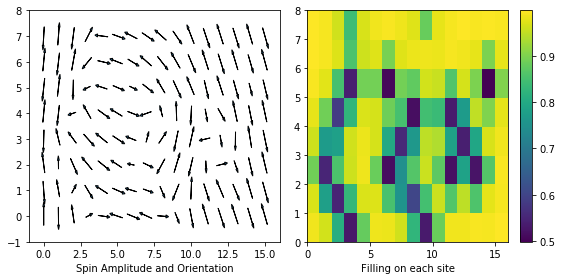

17600
0.772617331565324


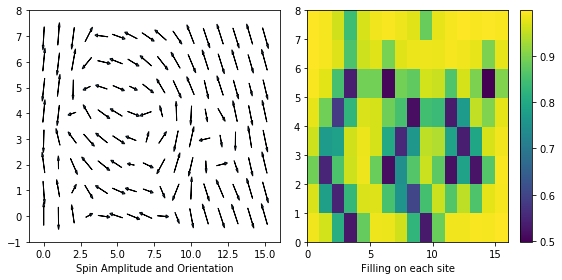

17700
0.7726178593326667


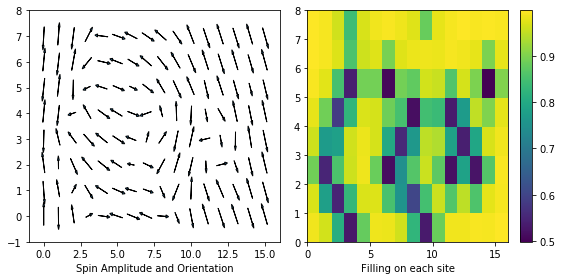

17800
0.7726183517460862


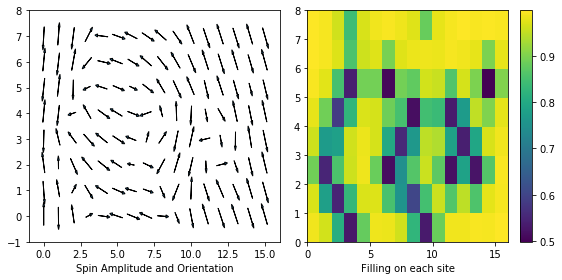

17900
0.7726188234879545


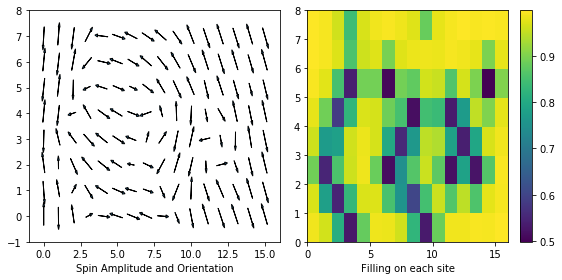

18000
0.7726192754251422


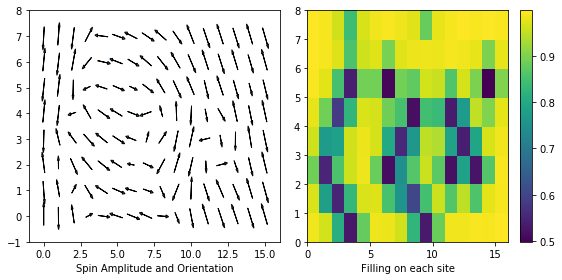

18100
0.7726196910146663


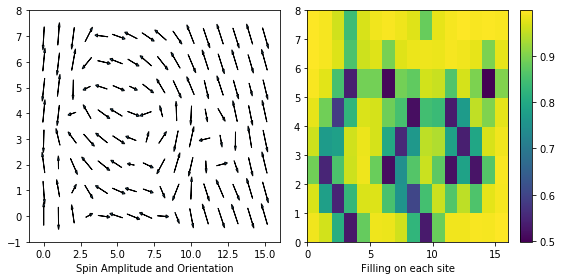

18200
0.7726200840332932


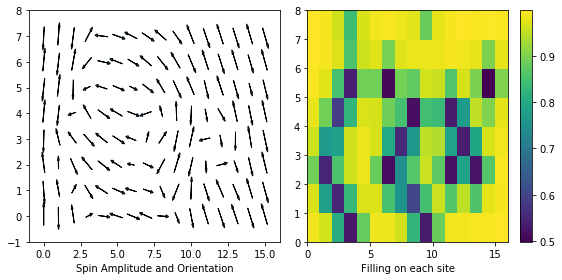

18300
0.7726204476037035


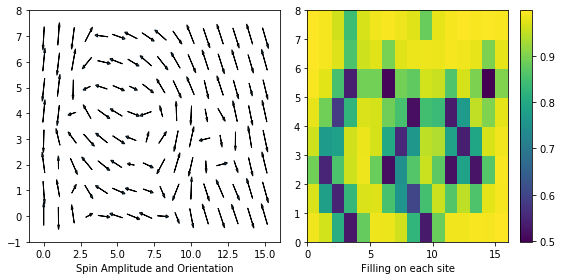

18400
0.772620795307649


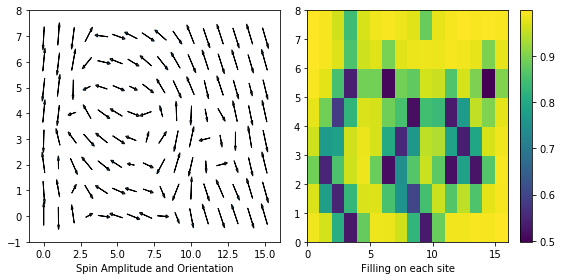

18500
0.7726211259557678


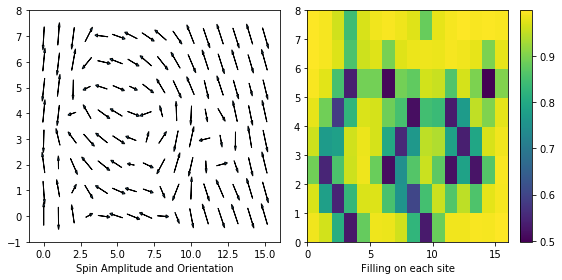

18600
0.7726214366392524


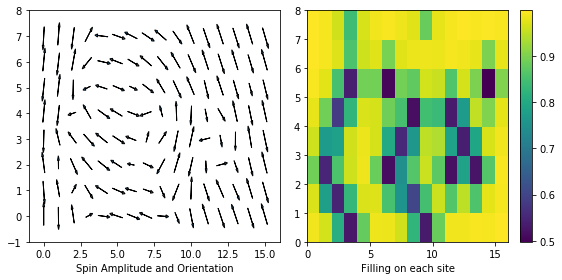

18700
0.7726217357856875


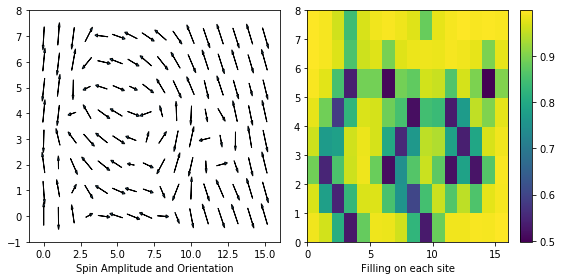

18800
0.7726220121147278


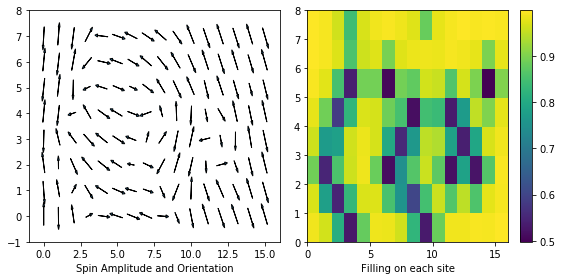

18900
0.7726222777850009


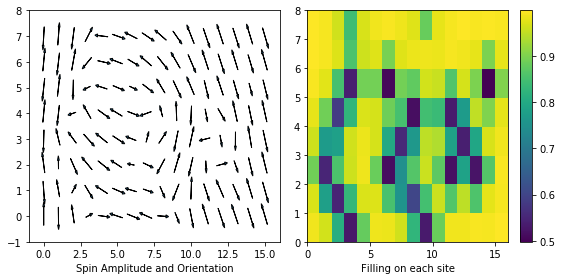

19000
0.7726225245820488


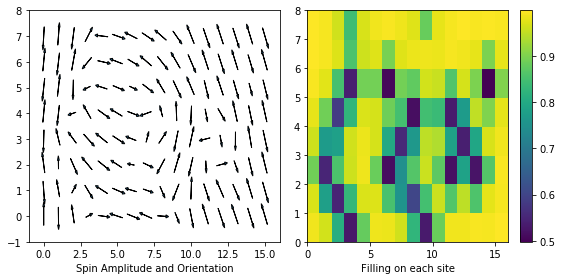

19100
0.7726227543082453


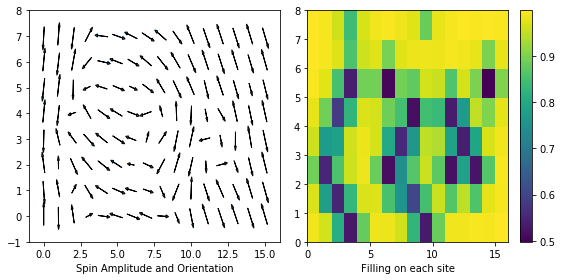

19200
0.7726229715948998


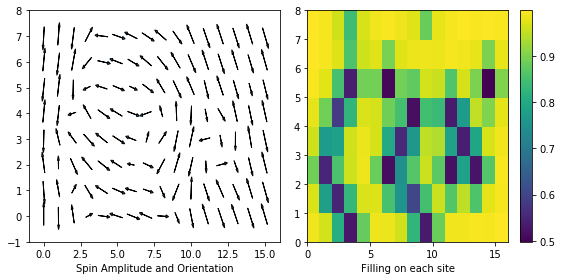

19300
0.7726231778622494


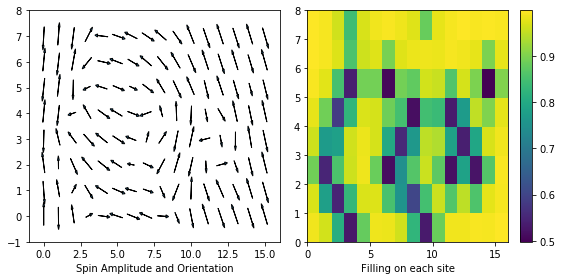

19400
0.7726233721512603


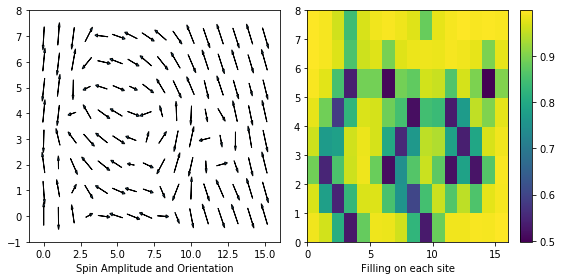

19500
0.7726235558142635


KeyboardInterrupt: 

In [166]:
###If one wants to access the energies for each iteration.

#RandVec = np.random.random(N_tot)
#RandVec2 = RandVec # =RandVec, if we want to enforce the polarization plane to lie in x-y-plane.
#GapVector = np.append(RandVec,np.append(RandVec2,np.random.random(2*N_tot)-0.5))

#Energies = []
for i in range(len(Energies_Stripes_tprime0)-len(Energies)):
    if(i%100 == 0 or i == 20):
        print(i)
        Plot_Arrows(GapVector)
        
    NewGapVector, NewEnergy = Next_Gap_Vector(GapVector,GetEnergy=True,ReturnBoth = True)
    Energies.append(NewEnergy)
    Mixing = 0.3*np.random.random()
    GapVector = Mixing*GapVector + (1-Mixing)*NewGapVector

-0.583128899930871


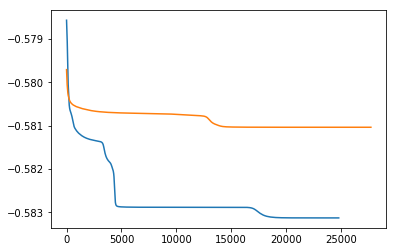

In [168]:
#Energies_Stripes_tprime0 = Energies
#GapVector_Stripes = GapVector
print(Energies[-1])
plt.plot(Energies[200:])
plt.plot(Energies_Stripes_tprime0[200:])
#plt.plot(Energies_Stripes[2:])
plt.show()

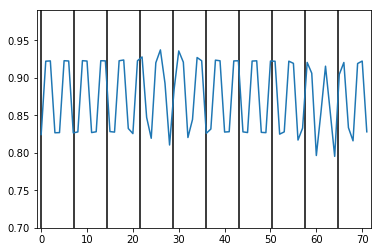

In [126]:
N_ups = GapVector[:N_tot]
N_downs = GapVector[N_tot:2*N_tot]
N_s = N_ups+N_downs

plt.plot(N_s[:N_x])
#plt.plot(N_s[N_x:2*N_x])
#plt.plot(N_s[2*N_x:3*N_x])
#plt.plot(N_s[3*N_x:4*N_x])

VLINES = []
for i in range(10):
    VLINES.append(i*7.2)
plt.vlines(VLINES,0.6,1)
plt.ylim(0.7,0.99)
plt.xlim(-1,72)
plt.show()

In [ ]:
#np.save("Energies/Energy_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_FromStripes.npy".format(N_x,N_y,U,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y),Energies)

In [163]:
###np.save("GapVectors_Withdoping/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}.npy".format(N_x,N_y,U,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y),GapVector)